# Phase 1: Jigsaw Puzzle Edge Detection Pipeline

This pipeline processes puzzle images to detect and enhance piece edges:
1. Load puzzle images (2x2, 4x4, 8x8 grids)
2. Detect grid size automatically
3. Split into individual pieces
4. Apply edge detection (CLAHE + Bilateral Filter + Canny)
5. Save processed artifacts for analysis


## 1. Imports and Configuration


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from pathlib import Path
from PIL import Image
from image_utils import load_image, detect_grid_size, split_image

%matplotlib inline


In [23]:
# Configuration
BASE_DIR = "./Gravity Falls"
OUTPUT_DIR = "./processed_artifacts"

# Processing parameters
GAUSSIAN_KERNEL_SIZE = (5, 5)
CANNY_THRESHOLD_LOW = 50
CANNY_THRESHOLD_HIGH = 150
CLAHE_CLIP_LIMIT = 2.0
CLAHE_TILE_GRID_SIZE = (8, 8)
MORPH_KERNEL_SIZE = (3, 3)

# Create output directory structure
os.makedirs(OUTPUT_DIR, exist_ok=True)
for puzzle_type in ['puzzle_2x2', 'puzzle_4x4', 'puzzle_8x8']:
    os.makedirs(os.path.join(OUTPUT_DIR, puzzle_type), exist_ok=True)


## 2. Enhancement Functions for Puzzle Pieces


In [24]:
def visualize_grid_detection(image, grid_size):
    """Visualize gradient analysis for grid detection."""
    if len(image.shape) == 3:
        gray = np.mean(image, axis=2)
    else:
        gray = image
    
    grad_y = np.abs(np.diff(gray, axis=0))
    grad_x = np.abs(np.diff(gray, axis=1))
    row_profile = np.mean(grad_y, axis=1)
    col_profile = np.mean(grad_x, axis=0)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes[0, 0].imshow(gray, cmap='gray')
    axes[0, 0].set_title('Grayscale Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(grad_y, cmap='hot')
    axes[0, 1].set_title('Vertical Gradients')
    axes[0, 1].axis('off')
    
    axes[1, 0].plot(row_profile)
    axes[1, 0].set_title(f'Row Profile (Detected: {grid_size}x{grid_size})')
    axes[1, 0].set_xlabel('Row')
    axes[1, 0].set_ylabel('Gradient Intensity')
    
    axes[1, 1].plot(col_profile)
    axes[1, 1].set_title('Column Profile')
    axes[1, 1].set_xlabel('Column')
    axes[1, 1].set_ylabel('Gradient Intensity')
    
    plt.tight_layout()
    plt.show()

def visualize_patches(patches, grid_size):
    """Visualize split patches with indices."""
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    
    if grid_size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    for idx, ax in enumerate(axes):
        if idx < len(patches):
            ax.imshow(patches[idx])
            ax.set_title(f"Piece {idx}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def enhance_puzzle_piece(patch, apply_clahe=True, apply_morphology=True):
    """Edge detection pipeline for puzzle pieces.
    
    Steps:
    1. Grayscale conversion
    2. CLAHE contrast enhancement
    3. Bilateral filtering (noise reduction + edge preservation)
    4. Gaussian smoothing
    5. Canny edge detection
    6. Morphological closing (connect broken edges)
    """
    processing_steps = {}

    image_gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    processing_steps['grayscale'] = image_gray.copy()
    
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(image_gray)
    processing_steps['clahe'] = enhanced.copy()
    
    bilateral = cv2.bilateralFilter(enhanced, 9, 75, 75)
    processing_steps['bilateral'] = bilateral.copy()
    
    image_blurred = cv2.GaussianBlur(bilateral, (3, 3), 0)
    processing_steps['blurred'] = image_blurred.copy()
    
    edges = cv2.Canny(image_blurred, threshold1=30, threshold2=100)
    processing_steps['canny_edges'] = edges.copy()
    
    kernel = np.ones((2, 2), np.uint8)
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    processing_steps['morphology'] = edges_closed.copy()
    
    return image_blurred, edges_closed, processing_steps


In [25]:
def process_puzzle_image(image_path, output_base_dir, save_artifacts=True, visualize=False):
    """Process a single puzzle image through the edge detection pipeline."""
    path_parts = Path(image_path).parts
    puzzle_type = None
    image_id = None
    
    for part in path_parts:
        if 'puzzle_' in part:
            puzzle_type = part
        if part.endswith('.jpg') or part.endswith('.png'):
            image_id = Path(part).stem
    
    if puzzle_type is None or image_id is None:
        return None
    
    image = load_image(image_path)
    if image is None:
        return None
    
    grid_size = detect_grid_size(image_path)
    if grid_size is None:
        return None
    
    patches = split_image(image, grid_size)
    print(f"  Split into {len(patches)} pieces")
    
    if visualize:
        visualize_grid_detection(image, grid_size)
        visualize_patches(patches, grid_size)
    
    enhanced_patches = []
    edge_images = []
    
    for idx, patch in enumerate(patches):
        enhanced, edges, steps = enhance_puzzle_piece(patch)
        enhanced_patches.append(enhanced)
        edge_images.append(edges)
    
    # Step 5: Save artifacts
    if save_artifacts:
        image_output_dir = os.path.join(output_base_dir, puzzle_type, f"image_{image_id}")
        os.makedirs(image_output_dir, exist_ok=True)
        
        # Create subdirectories
        enhanced_dir = os.path.join(image_output_dir, "enhanced_pieces")
        edges_dir = os.path.join(image_output_dir, "edge_images")
        
        os.makedirs(enhanced_dir, exist_ok=True)
        os.makedirs(edges_dir, exist_ok=True)
        
        # Save enhanced pieces
        for idx, enhanced in enumerate(enhanced_patches):
            cv2.imwrite(os.path.join(enhanced_dir, f"piece_{idx:02d}_enhanced.png"), enhanced)
        
        # Save edge images
        for idx, edges in enumerate(edge_images):
            cv2.imwrite(os.path.join(edges_dir, f"piece_{idx:02d}_edges.png"), edges)
        
        # Save processing metadata
        metadata = {
            'image_path': str(image_path),
            'grid_size': grid_size,
            'num_pieces': len(patches),
            'image_shape': list(image.shape),
            'processing_parameters': {
                'gaussian_kernel_size': GAUSSIAN_KERNEL_SIZE,
                'canny_low': CANNY_THRESHOLD_LOW,
                'canny_high': CANNY_THRESHOLD_HIGH,
                'clahe_clip_limit': CLAHE_CLIP_LIMIT,
                'clahe_tile_size': CLAHE_TILE_GRID_SIZE
            }
        }
        
        with open(os.path.join(image_output_dir, "metadata.json"), 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"  Saved artifacts to {image_output_dir}")
    
    # Step 6: Visualization (optional)
    if visualize and len(patches) > 0:
        visualize_processing_results(patches, enhanced_patches, edge_images, grid_size)
    
    # Return summary
    return {
        'image_path': image_path,
        'puzzle_type': puzzle_type,
        'image_id': image_id,
        'grid_size': grid_size,
        'num_pieces': len(patches),
        'success': True
    }


In [26]:
def visualize_processing_results(original_patches, enhanced_patches, edge_images, grid_size, num_examples=4):
    """
    Visualize before/after processing results for a few example pieces.
    
    NOTE: All patches are processed and saved to disk. This function only displays
    a sample of patches (default: 4) to keep the visualization manageable.
    The patches are evenly distributed across the full set.
    
    Args:
        num_examples: Number of example patches to display (default: 4)
    """
    # Select a few pieces to visualize
    num_to_show = min(num_examples, len(original_patches))
    indices = np.linspace(0, len(original_patches) - 1, num_to_show, dtype=int)
    
    fig, axes = plt.subplots(num_to_show, 3, figsize=(12, 4 * num_to_show))
    
    if num_to_show == 1:
        axes = axes.reshape(1, -1)
    
    for row, idx in enumerate(indices):
        # Original patch
        axes[row, 0].imshow(original_patches[idx])
        axes[row, 0].set_title(f"Original Piece {idx}")
        axes[row, 0].axis('off')
        
        # Enhanced patch
        axes[row, 1].imshow(enhanced_patches[idx], cmap='gray')
        axes[row, 1].set_title(f"Enhanced Piece {idx}")
        axes[row, 1].axis('off')
        
        # Edge image
        axes[row, 2].imshow(edge_images[idx], cmap='gray')
        axes[row, 2].set_title(f"Edges Piece {idx}")
        axes[row, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


## 5. Test on Single Image


Processing puzzle_4x4/6...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_6


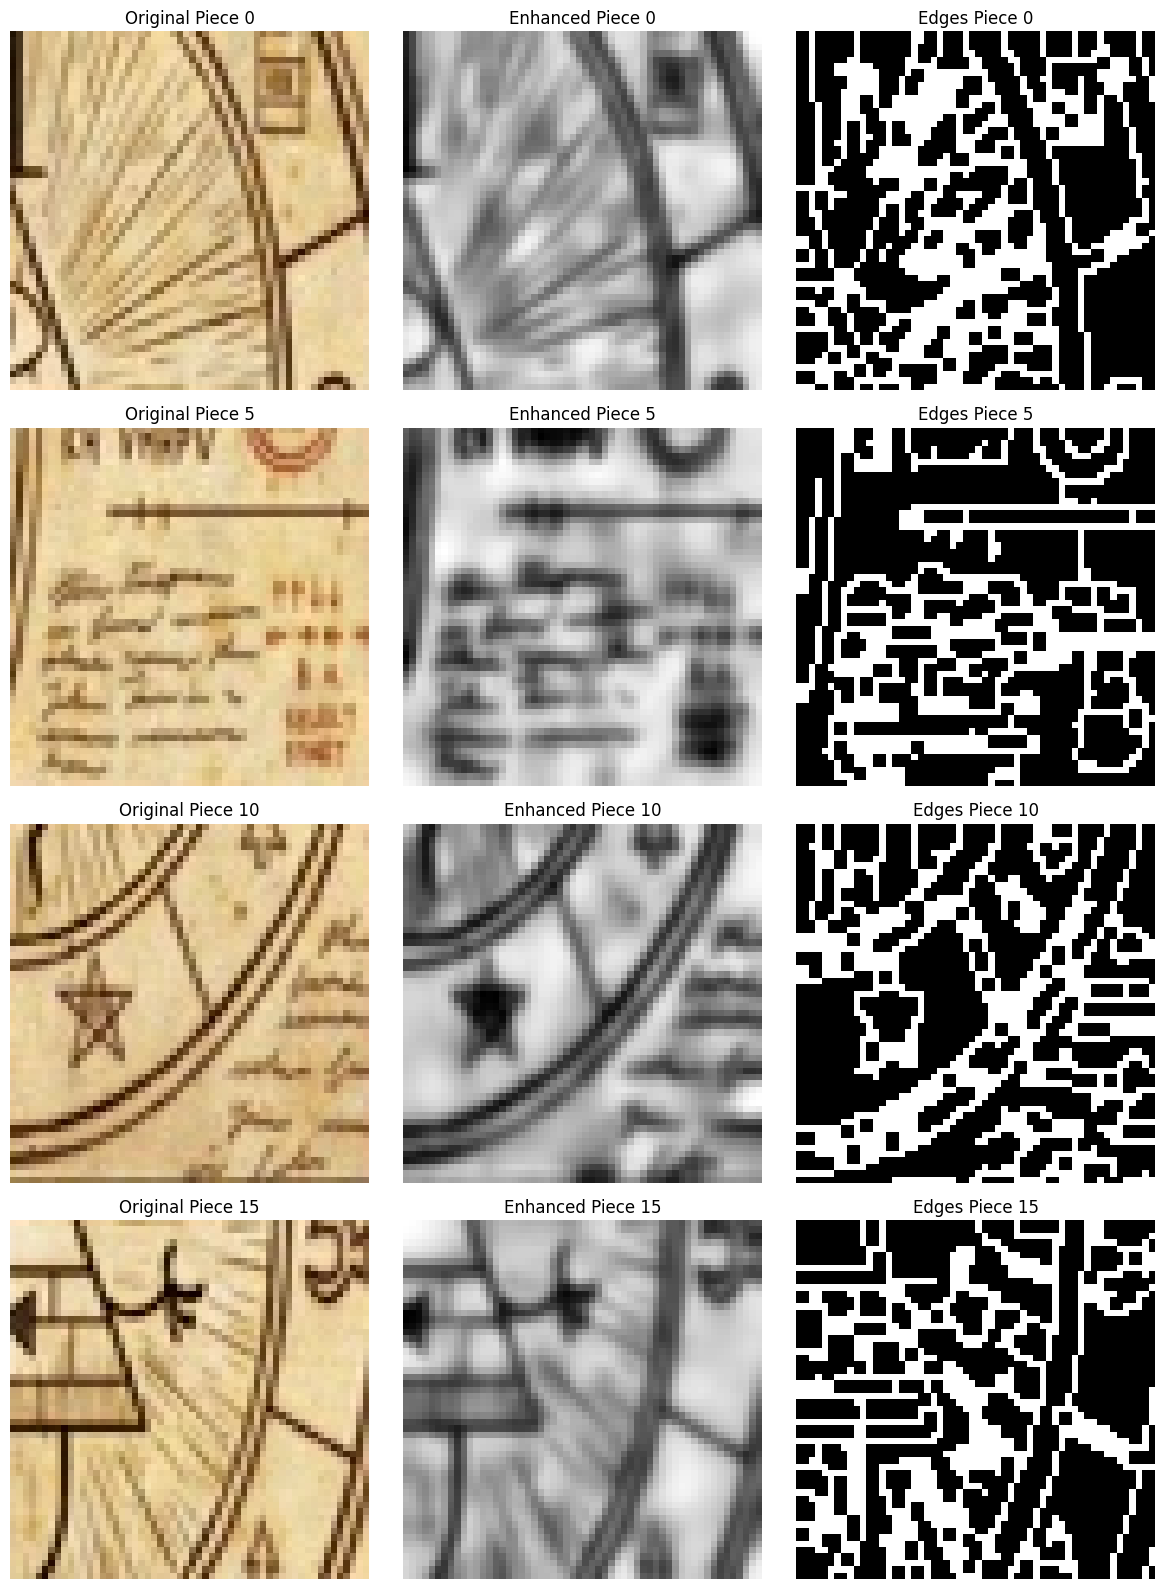


Processing Summary:
  Puzzle Type: puzzle_4x4
  Image ID: 6
  Grid Size: 4x4
  Number of Pieces: 16


In [27]:
# Test the pipeline on a single image
test_image_path = "./Gravity Falls/puzzle_4x4/6.jpg"

result = process_puzzle_image(
    test_image_path, 
    OUTPUT_DIR, 
    save_artifacts=True, 
    visualize=True
)

if result:
    print("\nProcessing Summary:")
    print(f"  Puzzle Type: {result['puzzle_type']}")
    print(f"  Image ID: {result['image_id']}")
    print(f"  Grid Size: {result['grid_size']}x{result['grid_size']}")
    print(f"  Number of Pieces: {result['num_pieces']}")


## 6. Batch Processing: Process Entire Dataset


In [28]:
def process_dataset(base_dir, output_dir, puzzle_types=None, max_images_per_type=None, visualize_every_n=10):
    """
    Process all images in the dataset.
    
    Args:
        base_dir: base directory containing puzzle folders
        output_dir: directory to save processed artifacts
        puzzle_types: list of puzzle types to process (None = all)
        max_images_per_type: maximum number of images to process per type (None = all)
        visualize_every_n: visualize every Nth image
    """
    if puzzle_types is None:
        puzzle_types = ['puzzle_2x2', 'puzzle_4x4', 'puzzle_8x8']
    
    all_results = []
    
    for puzzle_type in puzzle_types:
        puzzle_dir = os.path.join(base_dir, puzzle_type)
        
        if not os.path.exists(puzzle_dir):
            print(f"Directory not found: {puzzle_dir}")
            continue
        
        # Get all image files
        image_files = sorted([f for f in os.listdir(puzzle_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        
        if max_images_per_type:
            image_files = image_files[:max_images_per_type]
        
        print(f"\n{'='*60}")
        print(f"Processing {puzzle_type}: {len(image_files)} images")
        print(f"{'='*60}")
        
        for idx, image_file in enumerate(image_files):
            image_path = os.path.join(puzzle_dir, image_file)
            
            # Visualize every Nth image
            should_visualize = (idx % visualize_every_n == 0)
            
            result = process_puzzle_image(
                image_path, 
                output_dir, 
                save_artifacts=True, 
                visualize=should_visualize
            )
            
            if result:
                all_results.append(result)
            
            # Progress update
            if (idx + 1) % 10 == 0:
                print(f"  Progress: {idx + 1}/{len(image_files)} images processed")
    
    # Save overall summary
    summary = {
        'total_images_processed': len(all_results),
        'results_by_type': {},
        'processing_parameters': {
            'gaussian_kernel_size': GAUSSIAN_KERNEL_SIZE,
            'canny_low': CANNY_THRESHOLD_LOW,
            'canny_high': CANNY_THRESHOLD_HIGH,
            'clahe_clip_limit': CLAHE_CLIP_LIMIT,
            'clahe_tile_size': CLAHE_TILE_GRID_SIZE
        }
    }
    
    for result in all_results:
        puzzle_type = result['puzzle_type']
        if puzzle_type not in summary['results_by_type']:
            summary['results_by_type'][puzzle_type] = 0
        summary['results_by_type'][puzzle_type] += 1
    
    summary_path = os.path.join(output_dir, 'processing_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\n{'='*60}")
    print("Processing Complete!")
    print(f"Total images processed: {len(all_results)}")
    print(f"Summary saved to: {summary_path}")
    print(f"{'='*60}")
    
    return all_results, summary



Processing puzzle_2x2: 110 images
Processing puzzle_2x2/0...
Could not confidently detect grid size from content. Returning None.
Could not detect grid size for ./Gravity Falls\puzzle_2x2\0.jpg
Processing puzzle_2x2/1...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_1
Processing puzzle_2x2/10...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_10
Processing puzzle_2x2/100...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_100
Processing puzzle_2x2/101...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_101
Processing puzzle_2x2/102...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_102
Processing puzzle_2x2/103...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_103
Processing puzzle_2x2/104...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_104
Proces

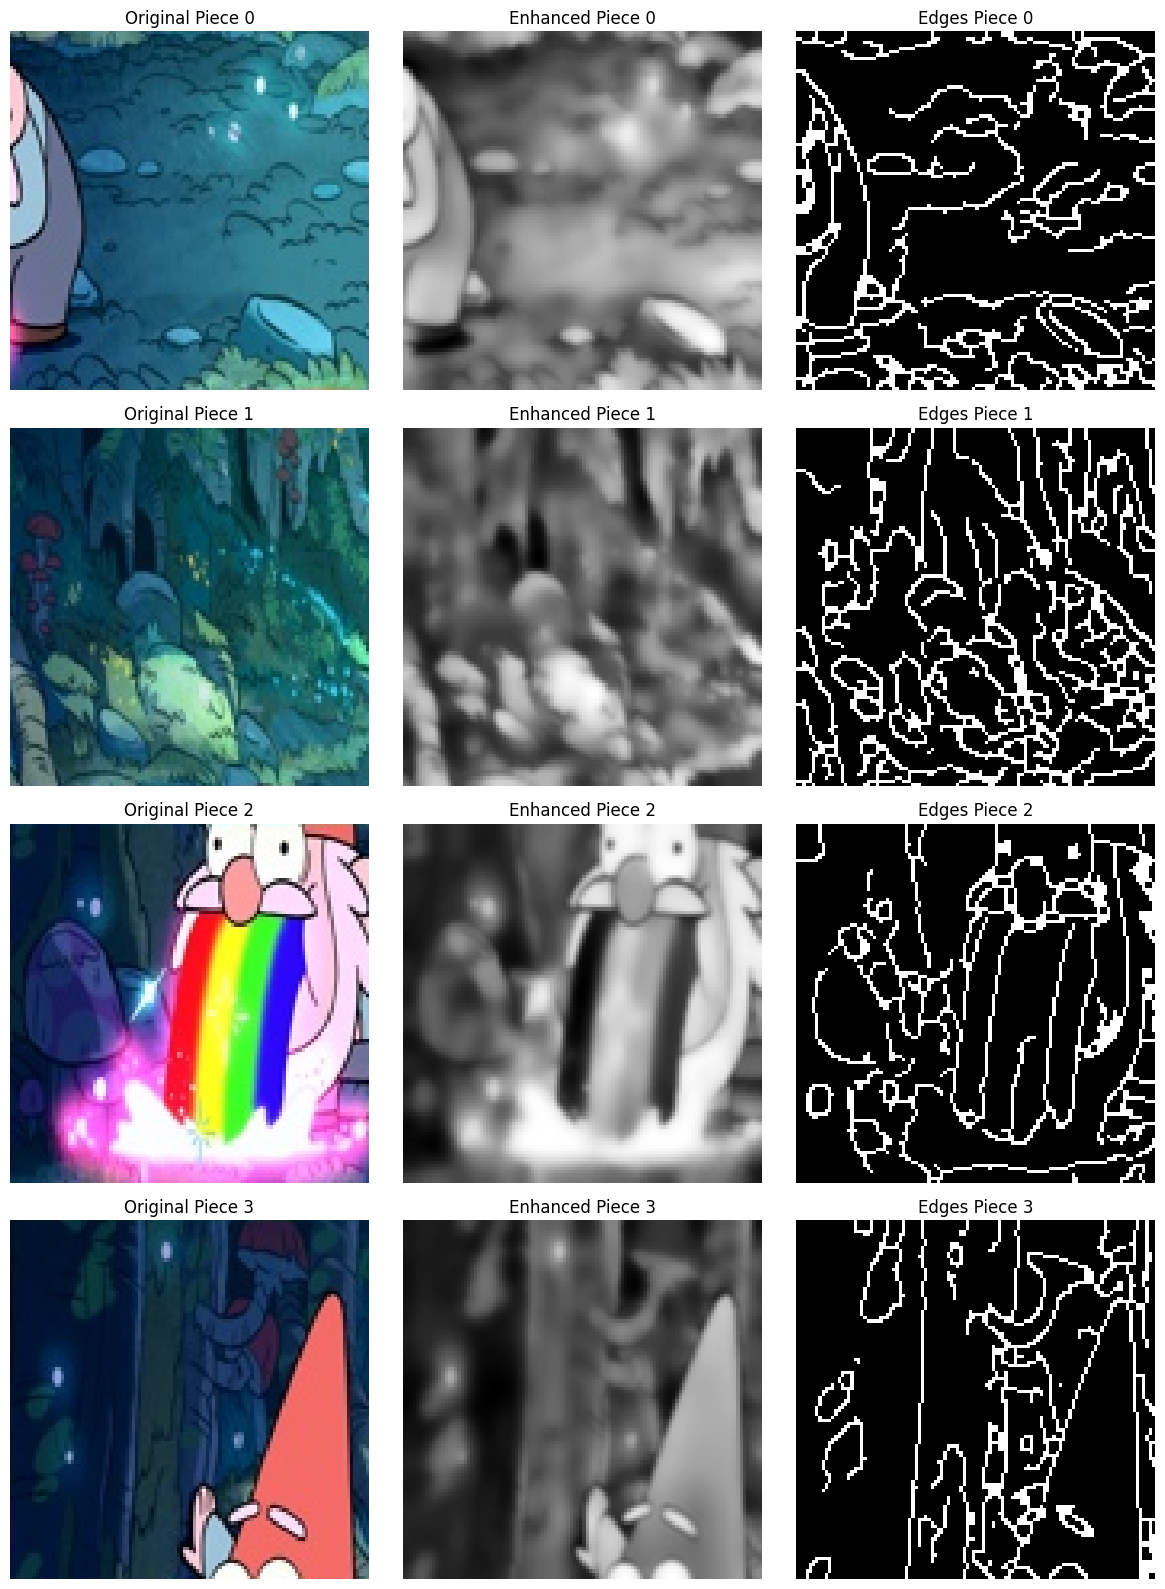

Processing puzzle_2x2/108...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_108
Processing puzzle_2x2/109...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_109
Processing puzzle_2x2/11...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_11
Processing puzzle_2x2/12...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_12
Processing puzzle_2x2/13...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_13
Processing puzzle_2x2/14...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_14
Processing puzzle_2x2/15...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_15
Processing puzzle_2x2/16...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_16
Processing puzzle_2x2/17...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts

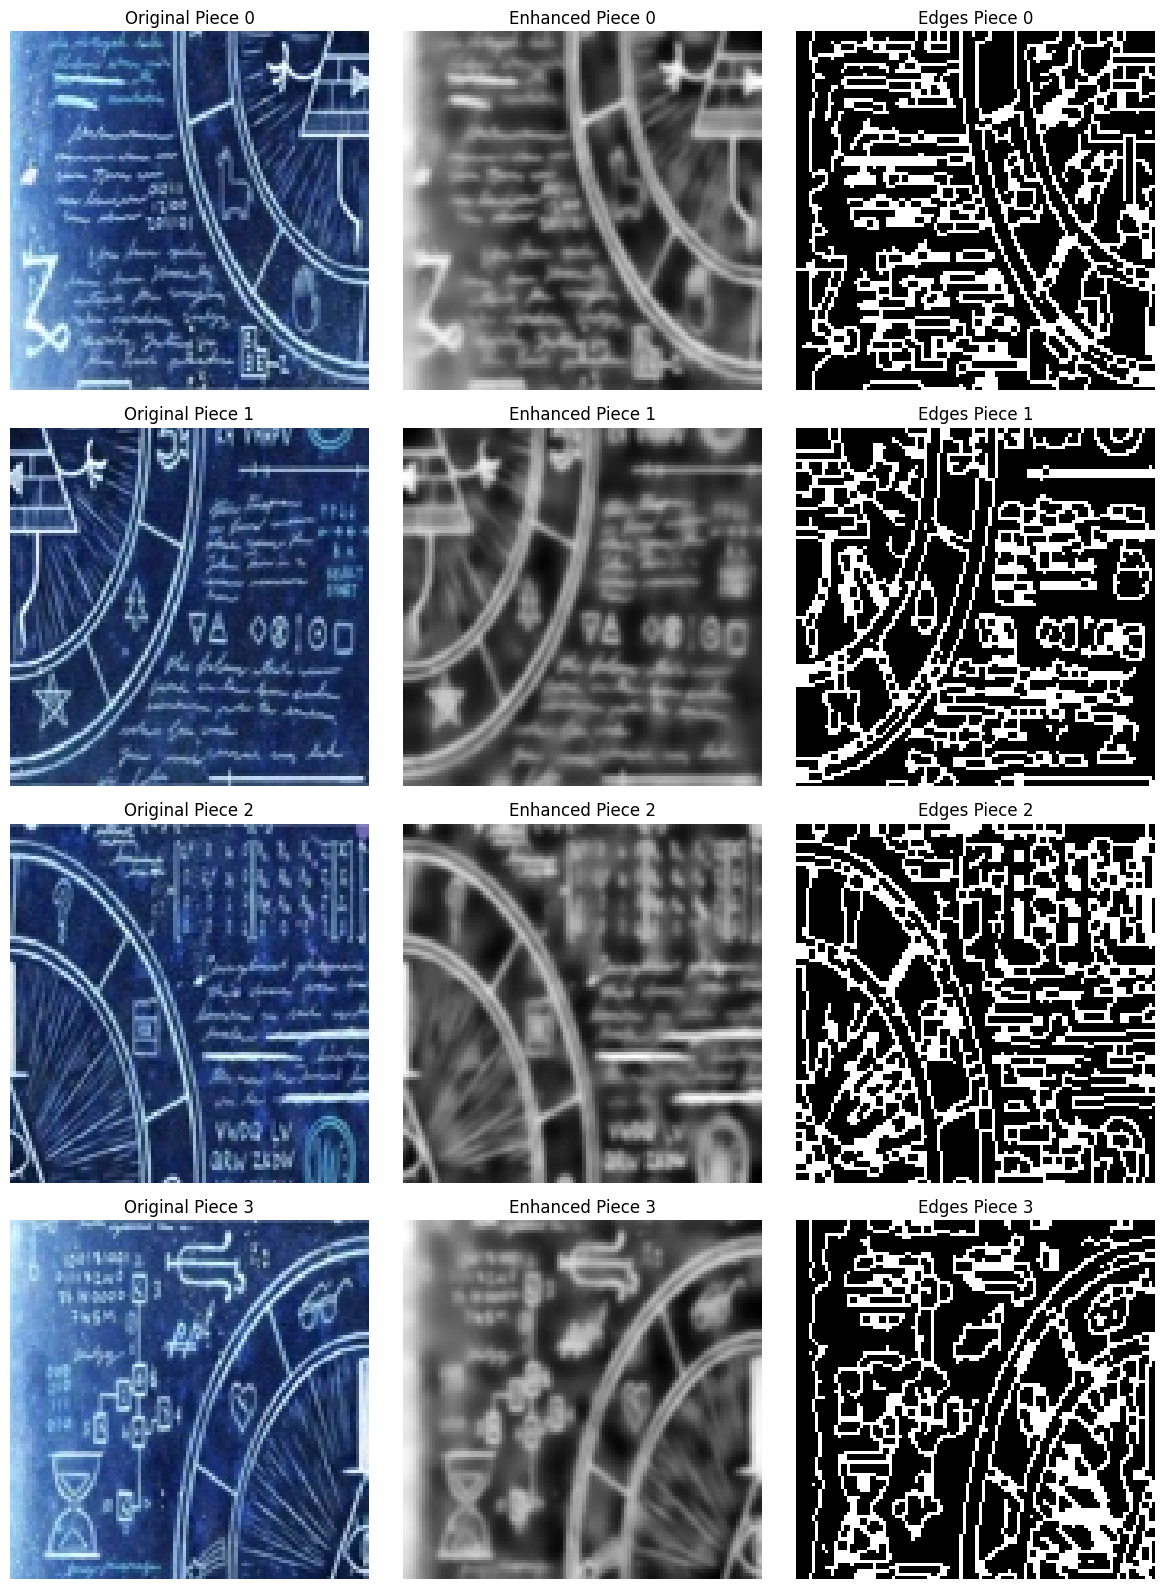

Processing puzzle_2x2/19...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_19
Processing puzzle_2x2/2...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_2
Processing puzzle_2x2/20...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_20
Processing puzzle_2x2/21...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_21
Processing puzzle_2x2/22...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_22
Processing puzzle_2x2/23...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_23
Processing puzzle_2x2/24...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_24
Processing puzzle_2x2/25...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_25
Processing puzzle_2x2/26...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzl

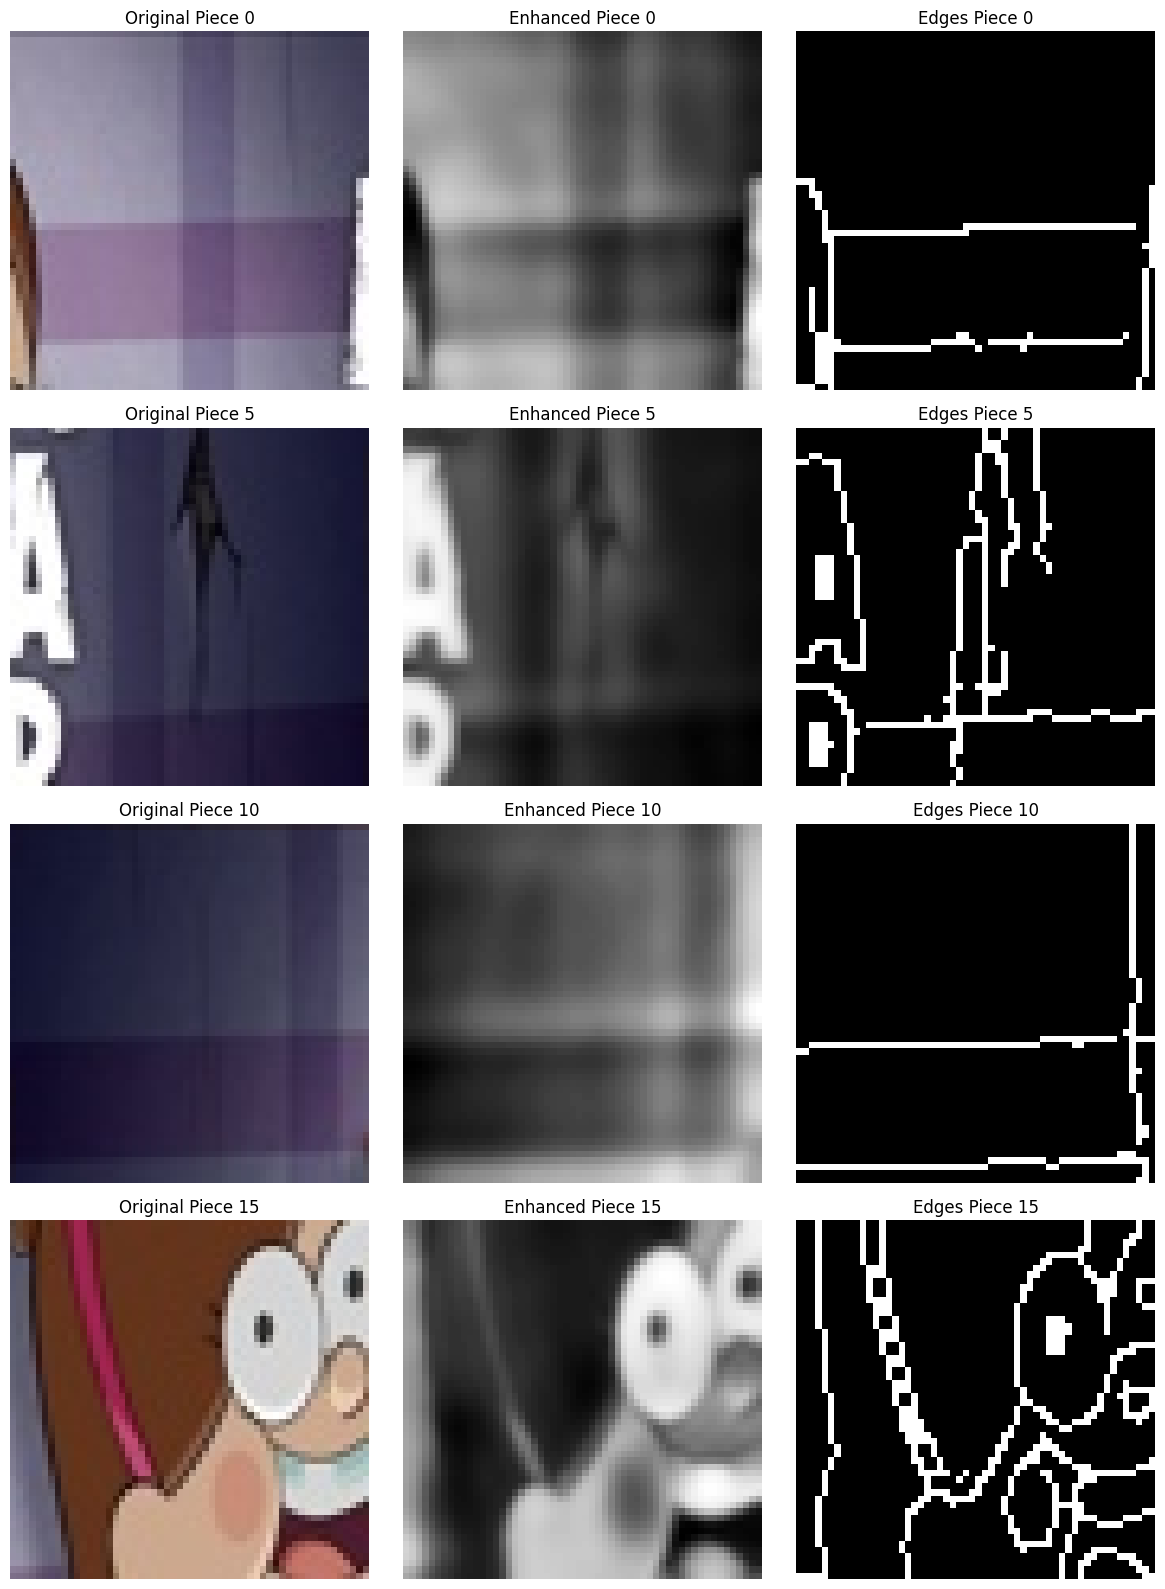

Processing puzzle_2x2/28...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_28
Processing puzzle_2x2/29...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_29
Processing puzzle_2x2/3...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_3
Processing puzzle_2x2/30...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_30
Processing puzzle_2x2/31...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_31
Processing puzzle_2x2/32...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_32
Processing puzzle_2x2/33...
Could not confidently detect grid size from content. Returning None.
Could not detect grid size for ./Gravity Falls\puzzle_2x2\33.jpg
Processing puzzle_2x2/34...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_34
Processing puzzle_2x2/35...
  Split into 4 piece

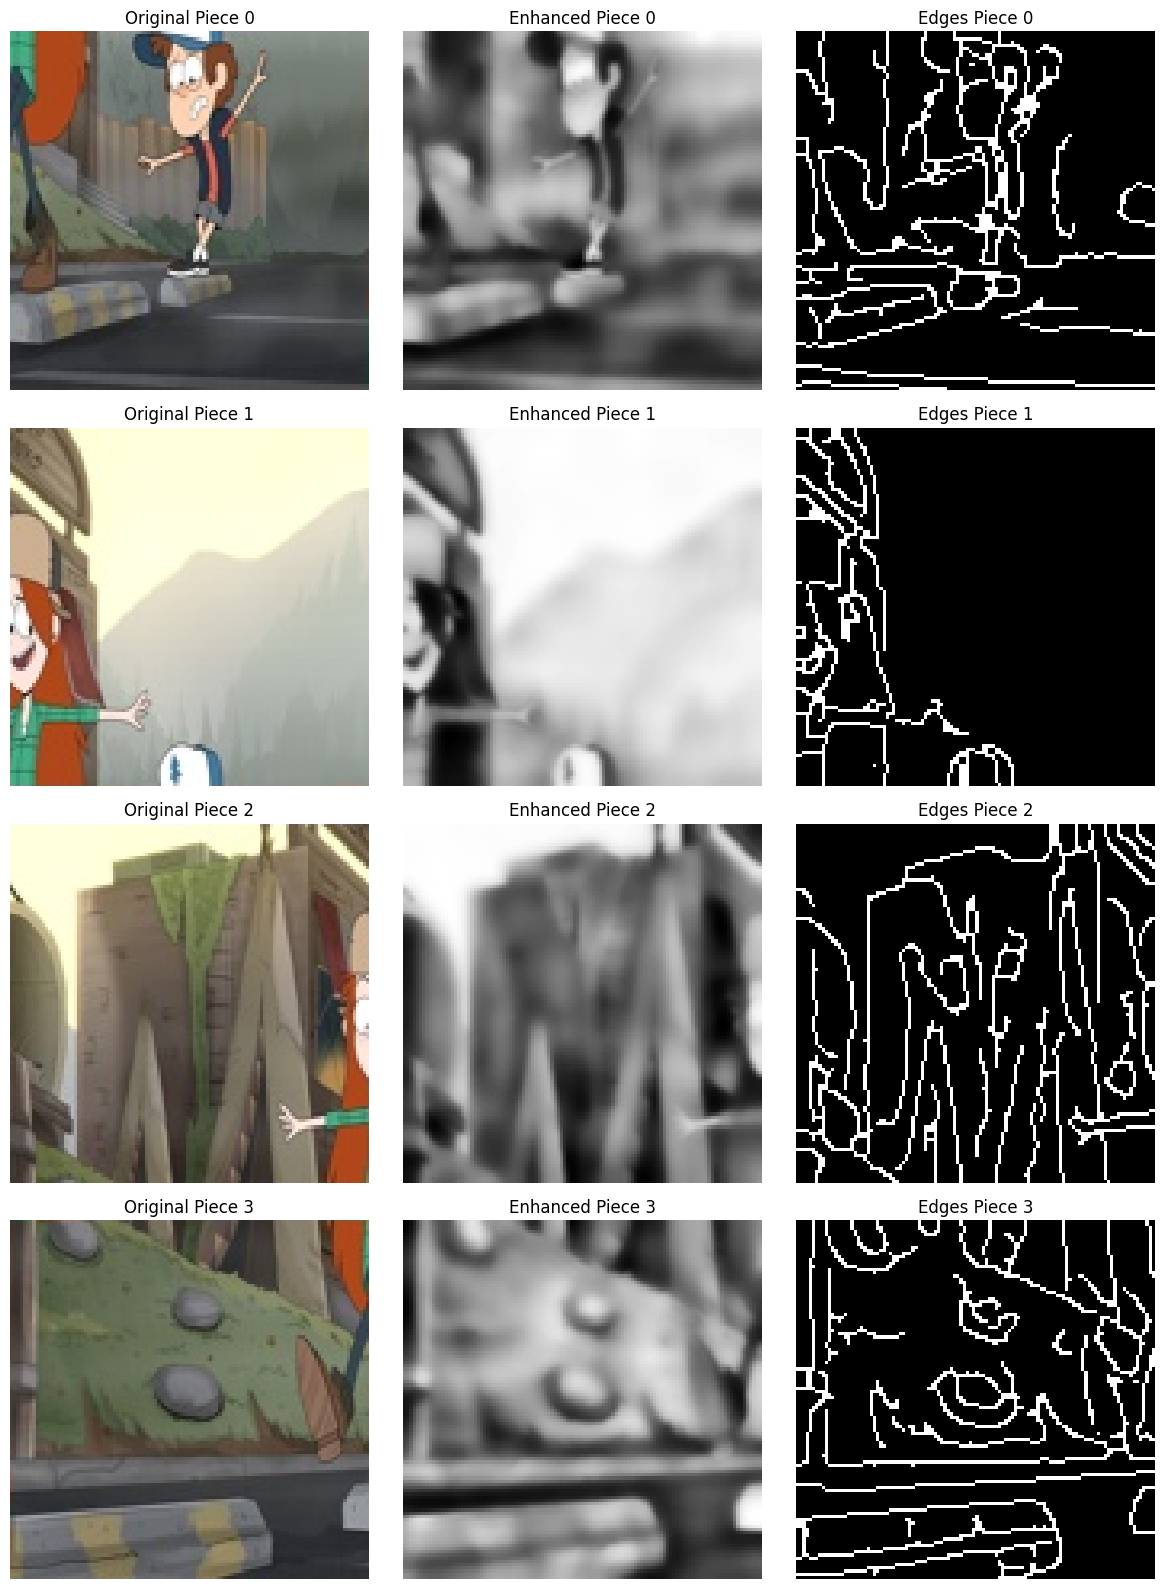

Processing puzzle_2x2/37...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_37
Processing puzzle_2x2/38...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_38
Processing puzzle_2x2/39...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_39
Processing puzzle_2x2/4...
Could not confidently detect grid size from content. Returning None.
Could not detect grid size for ./Gravity Falls\puzzle_2x2\4.jpg
Processing puzzle_2x2/40...
Could not confidently detect grid size from content. Returning None.
Could not detect grid size for ./Gravity Falls\puzzle_2x2\40.jpg
Processing puzzle_2x2/41...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_41
Processing puzzle_2x2/42...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_42
Processing puzzle_2x2/43...
Could not confidently detect grid size from content. Returning None.
Could not detec

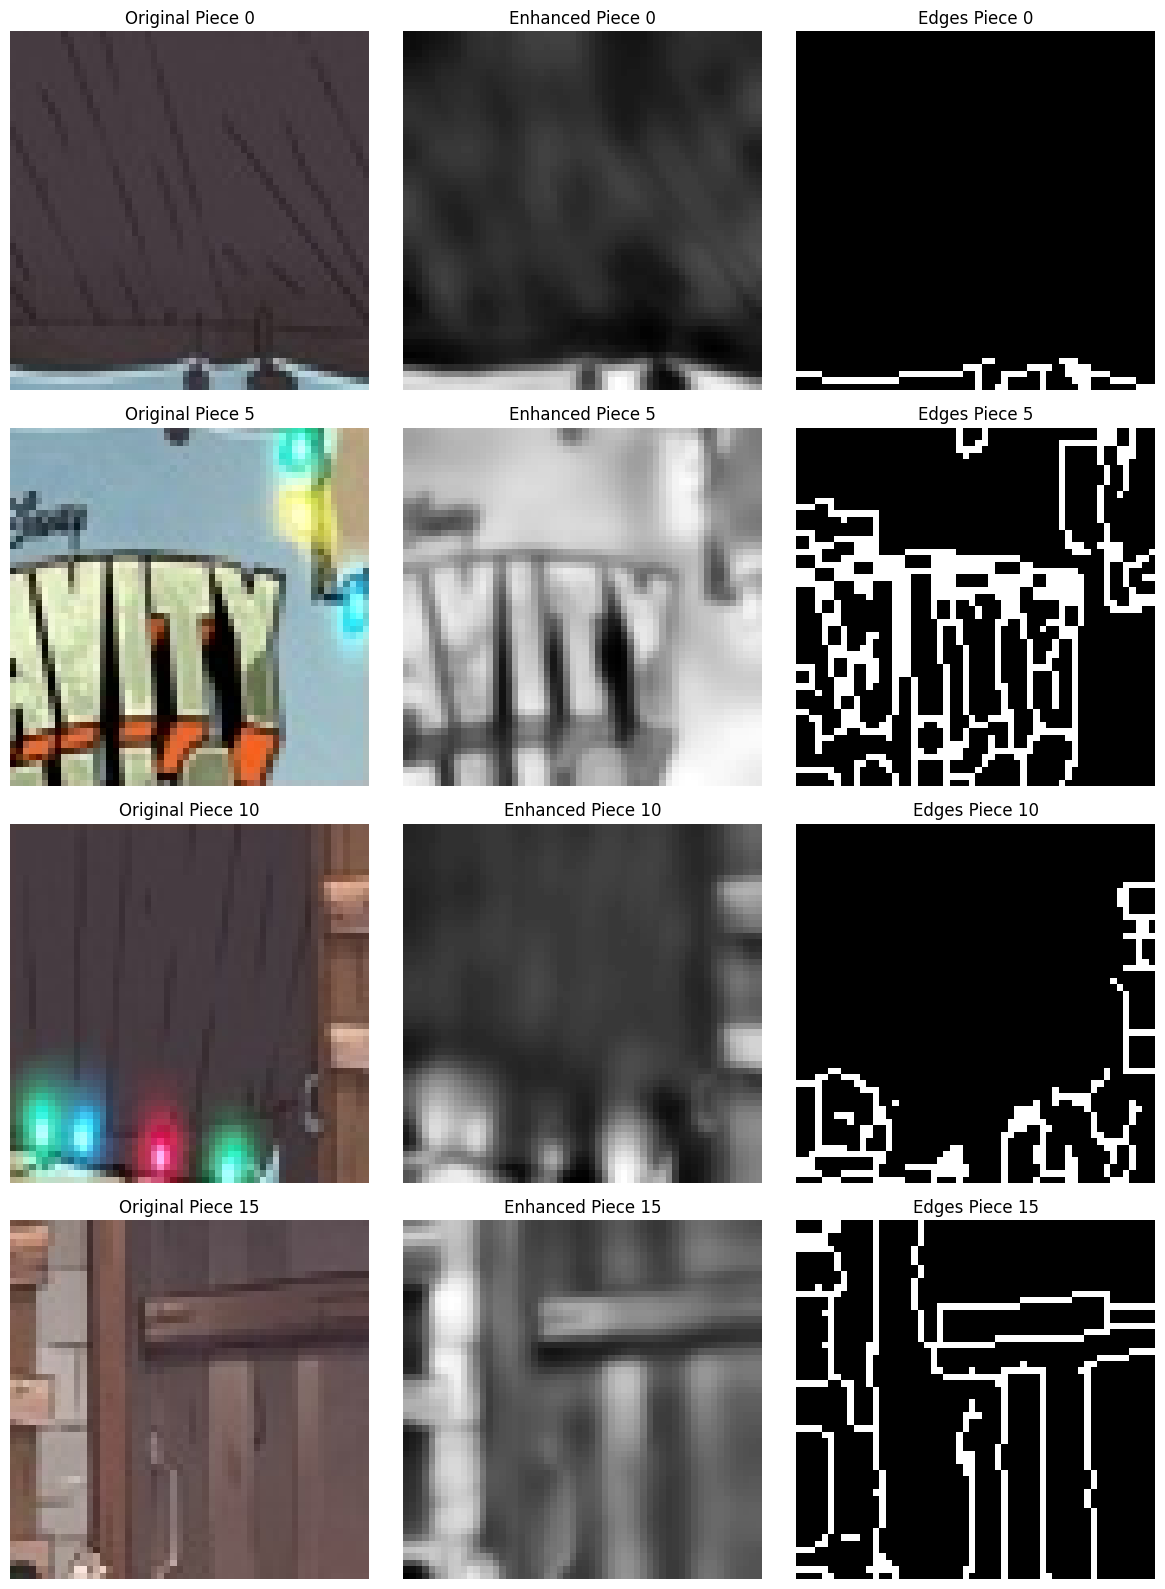

Processing puzzle_2x2/46...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_46
Processing puzzle_2x2/47...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_47
Processing puzzle_2x2/48...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_48
Processing puzzle_2x2/49...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_49
Processing puzzle_2x2/5...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_5
Processing puzzle_2x2/50...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_50
Processing puzzle_2x2/51...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_51
Processing puzzle_2x2/52...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_52
Processing puzzle_2x2/53...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzl

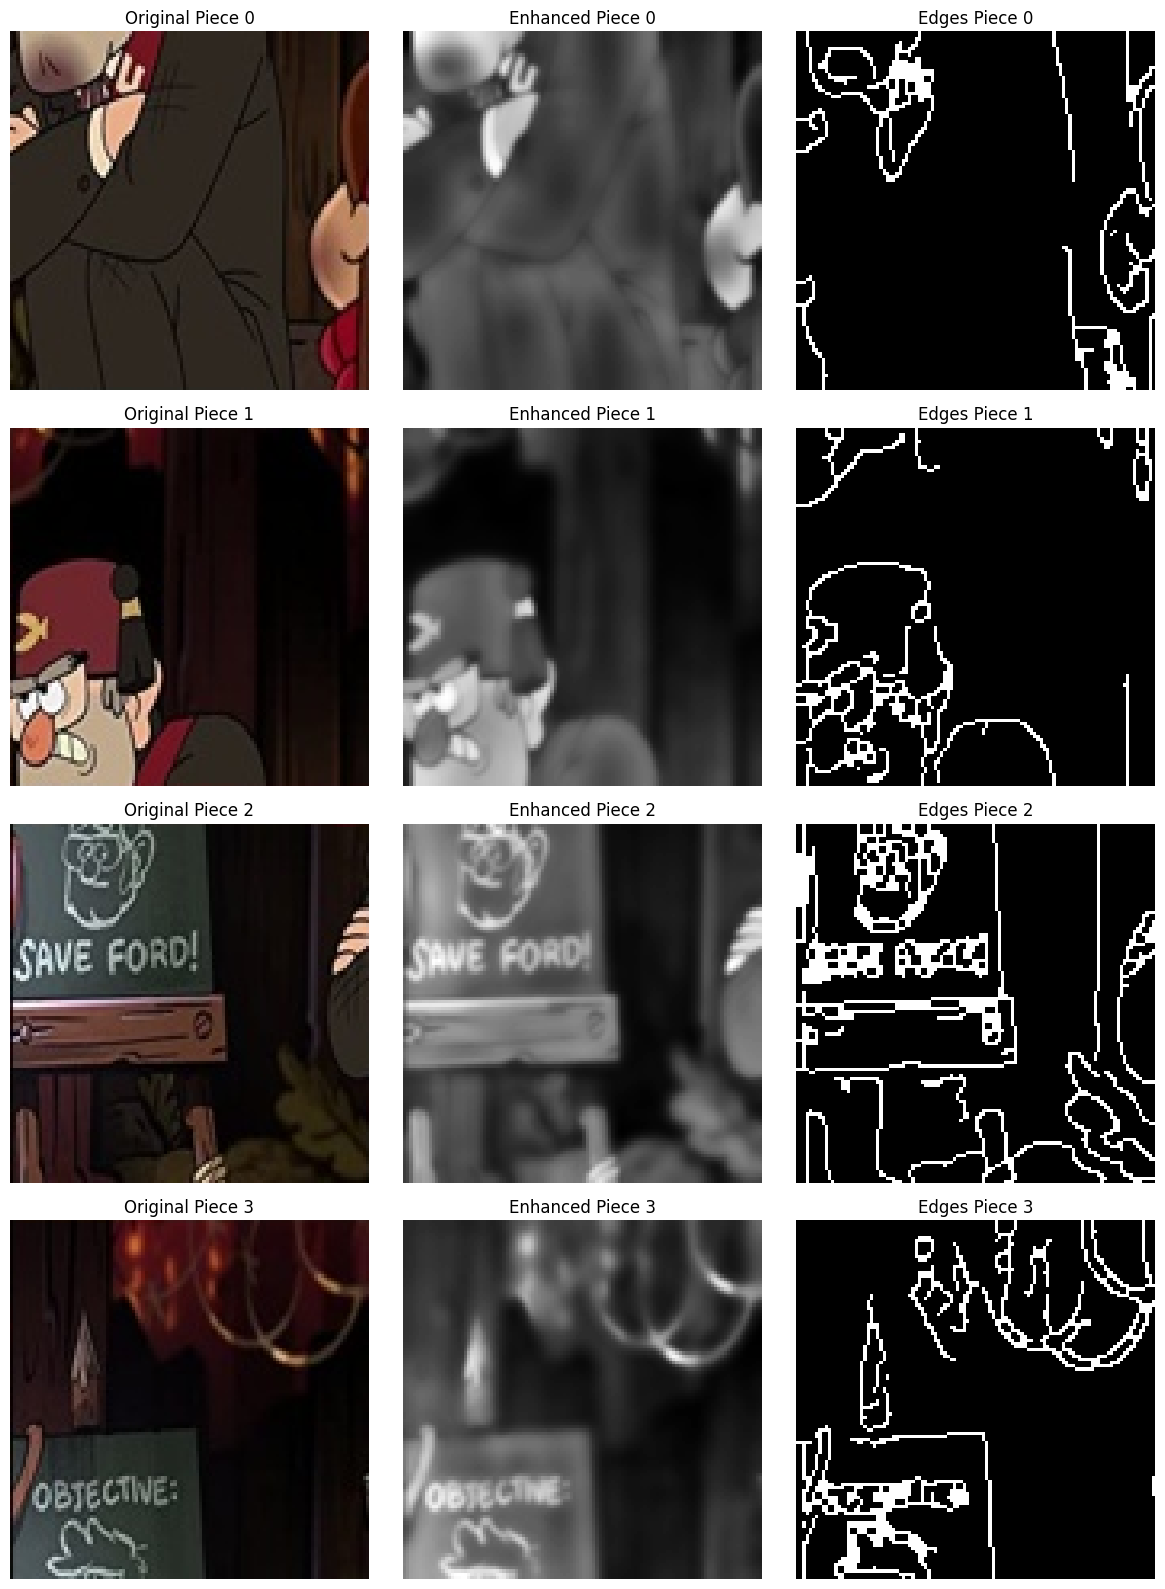

Processing puzzle_2x2/55...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_55
Processing puzzle_2x2/56...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_56
Processing puzzle_2x2/57...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_57
Processing puzzle_2x2/58...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_58
Processing puzzle_2x2/59...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_59
Processing puzzle_2x2/6...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_6
Processing puzzle_2x2/60...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_60
Processing puzzle_2x2/61...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_61
Processing puzzle_2x2/62...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzz

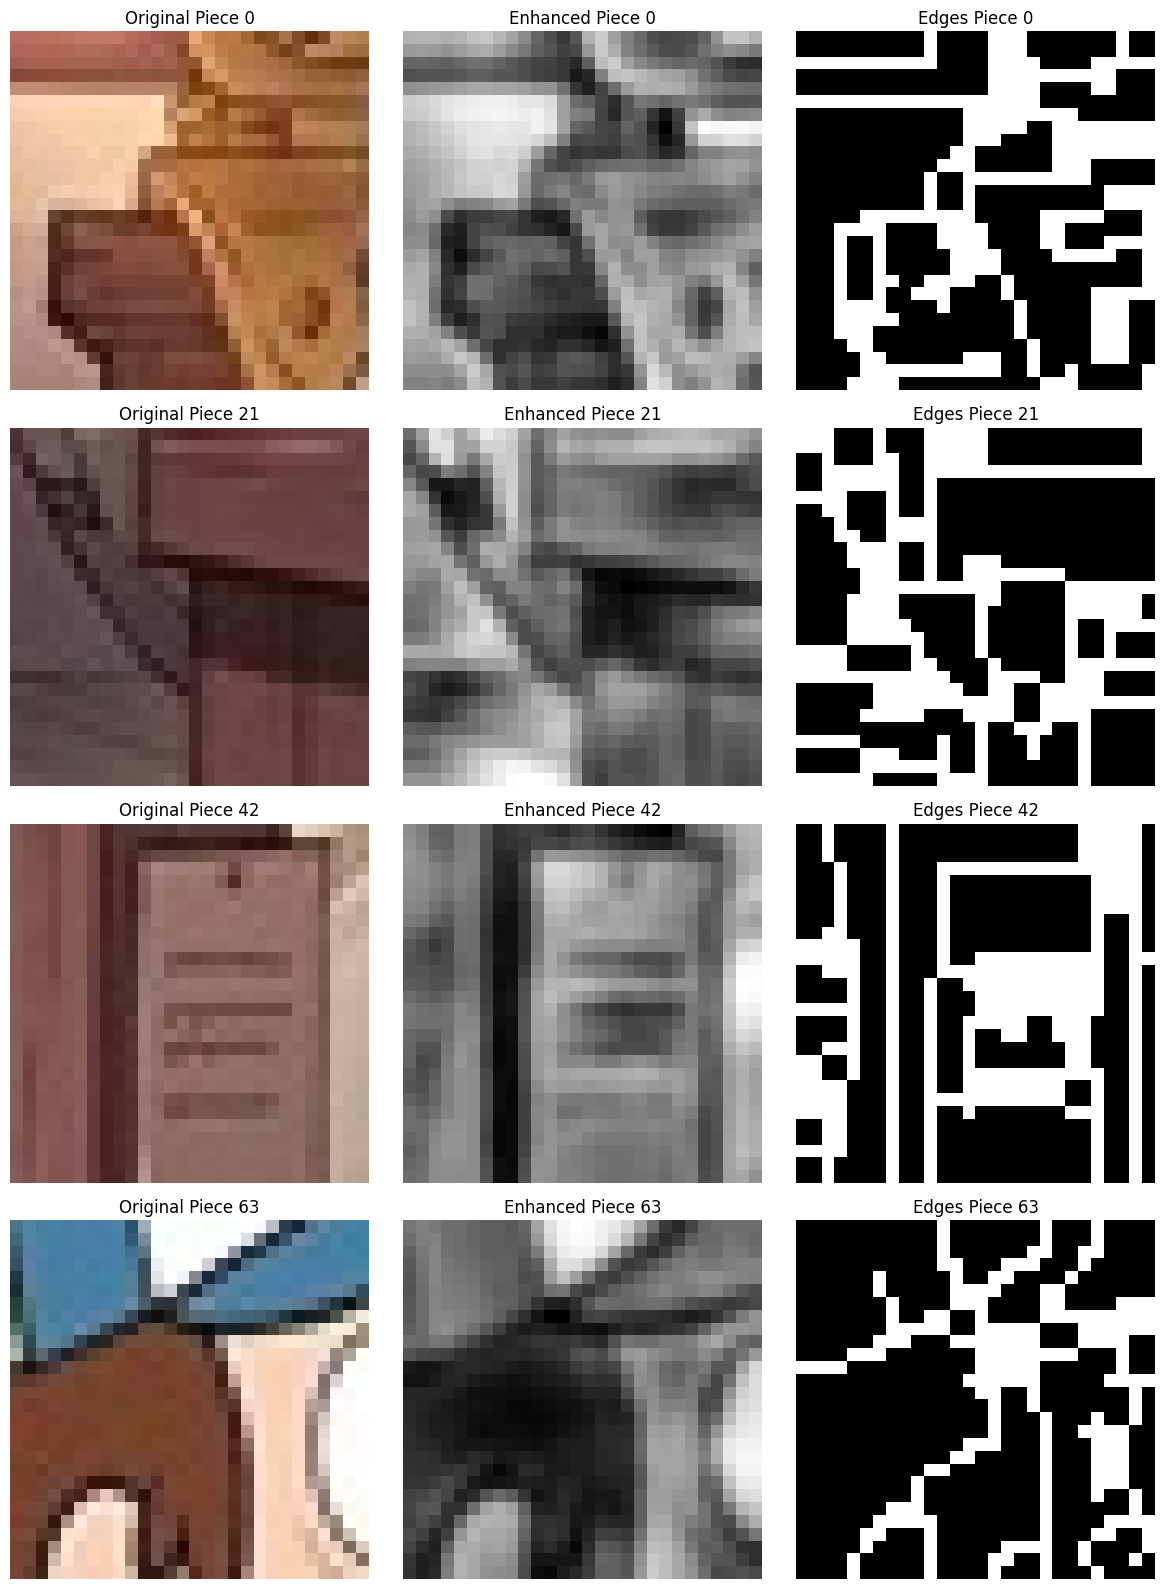

Processing puzzle_2x2/64...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_64
Processing puzzle_2x2/65...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_65
Processing puzzle_2x2/66...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_66
Processing puzzle_2x2/67...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_67
Processing puzzle_2x2/68...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_68
Processing puzzle_2x2/69...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_69
Processing puzzle_2x2/7...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_7
Processing puzzle_2x2/70...
Could not confidently detect grid size from content. Returning None.
Could not detect grid size for ./Gravity Falls\puzzle_2x2\70.jpg
Processing puzzle_2x2/71...
  Split into 4 piece

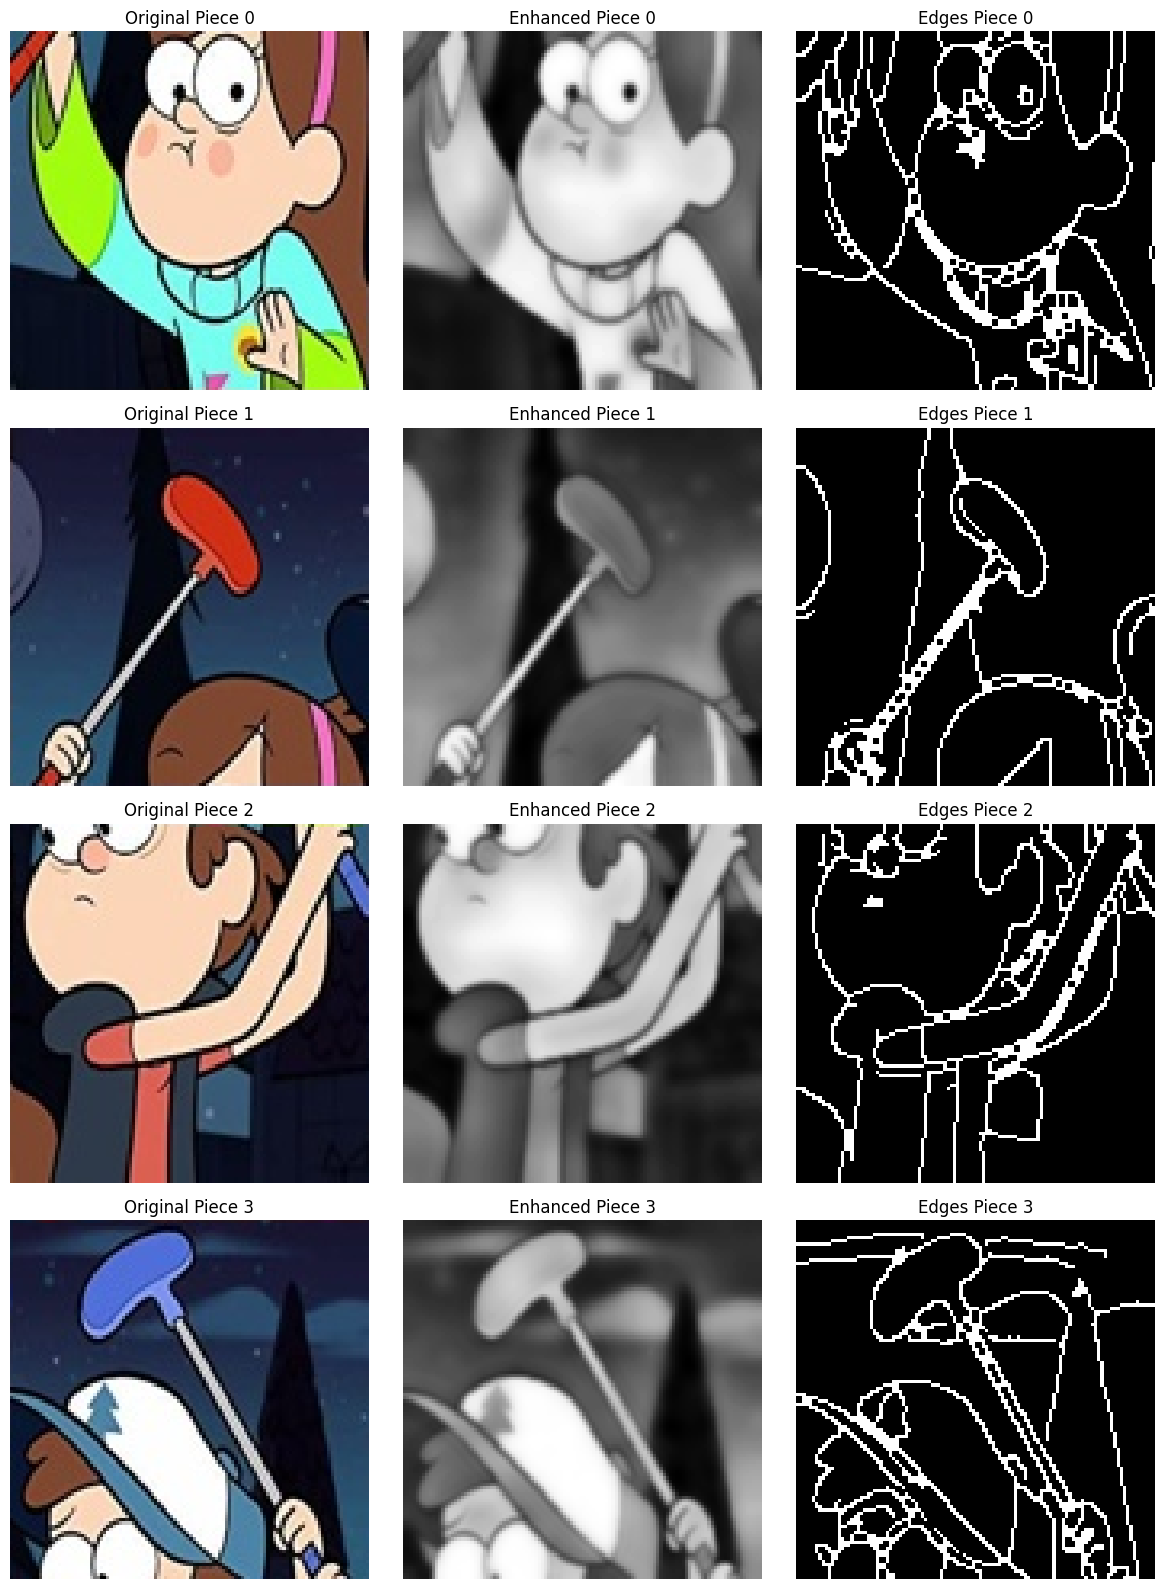

Processing puzzle_2x2/73...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_73
Processing puzzle_2x2/74...
Could not confidently detect grid size from content. Returning None.
Could not detect grid size for ./Gravity Falls\puzzle_2x2\74.jpg
Processing puzzle_2x2/75...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_75
Processing puzzle_2x2/76...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_76
Processing puzzle_2x2/77...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_77
Processing puzzle_2x2/78...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_78
Processing puzzle_2x2/79...
Could not confidently detect grid size from content. Returning None.
Could not detect grid size for ./Gravity Falls\puzzle_2x2\79.jpg
Processing puzzle_2x2/8...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_8


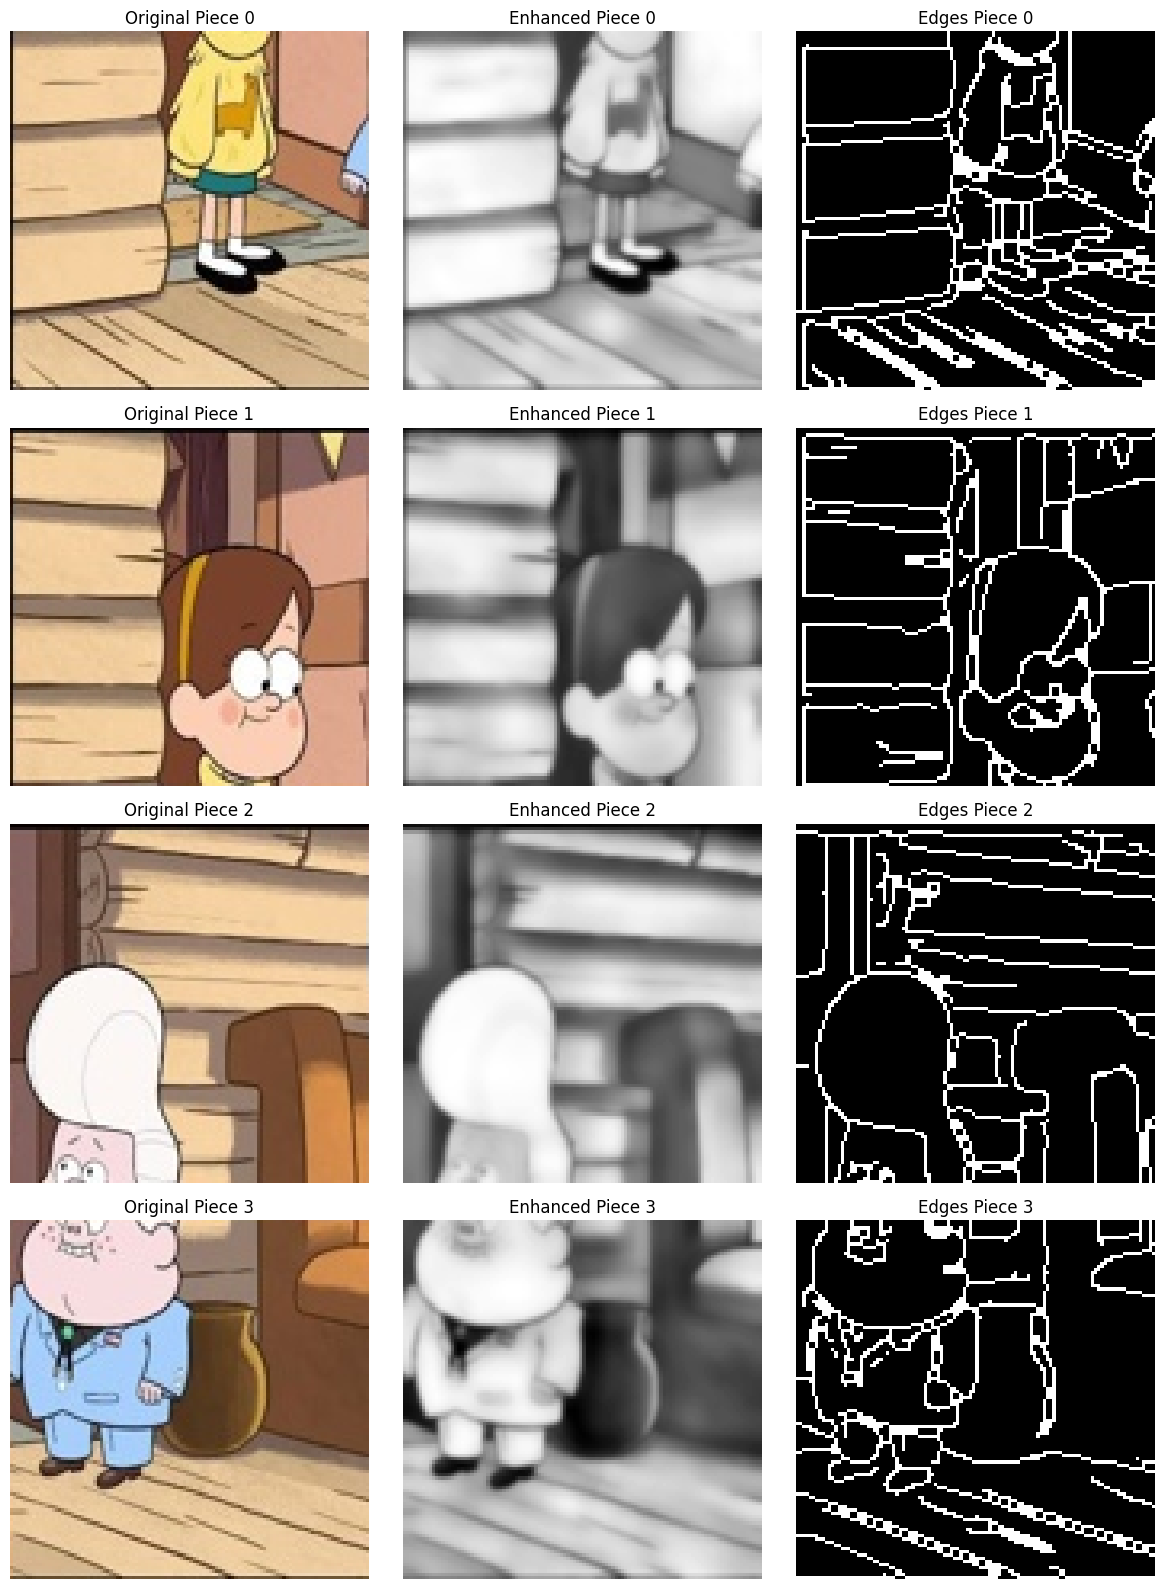

Processing puzzle_2x2/82...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_82
Processing puzzle_2x2/83...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_83
Processing puzzle_2x2/84...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_84
Processing puzzle_2x2/85...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_85
Processing puzzle_2x2/86...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_86
Processing puzzle_2x2/87...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_87
Processing puzzle_2x2/88...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_88
Processing puzzle_2x2/89...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_89
Processing puzzle_2x2/9...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\p

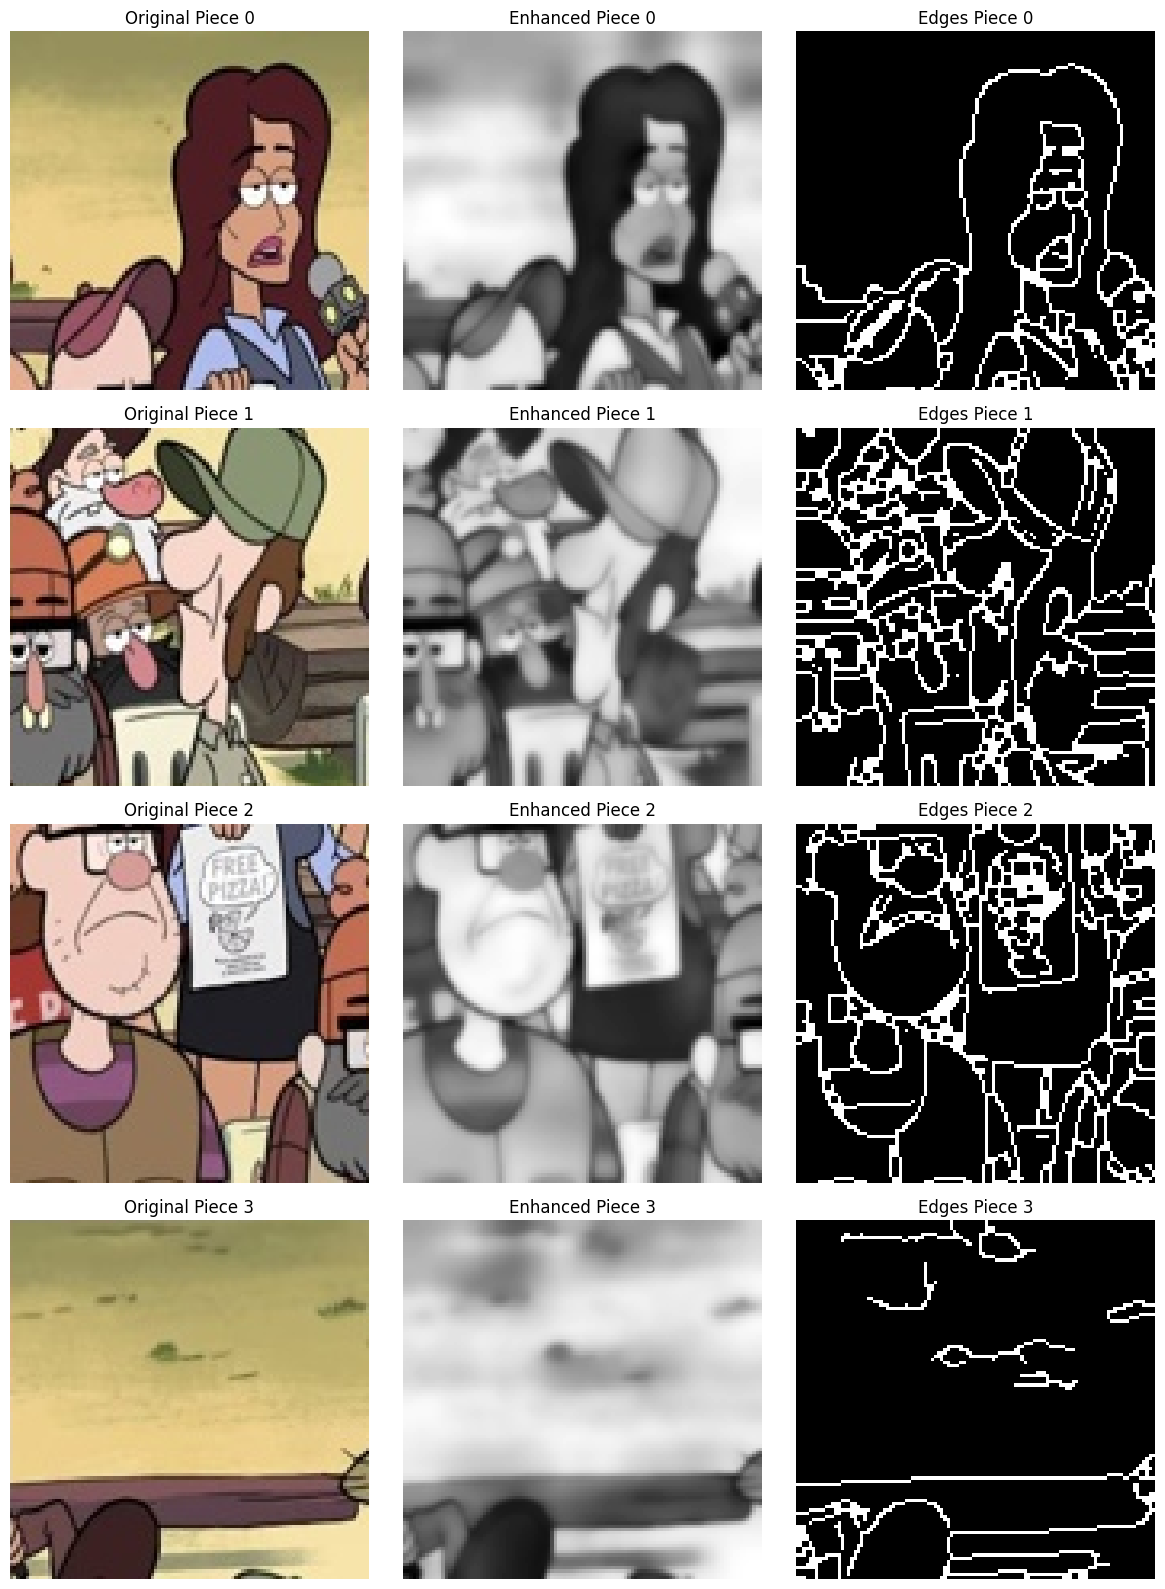

Processing puzzle_2x2/91...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_91
Processing puzzle_2x2/92...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_92
Processing puzzle_2x2/93...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_93
Processing puzzle_2x2/94...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_94
Processing puzzle_2x2/95...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_95
Processing puzzle_2x2/96...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_96
Processing puzzle_2x2/97...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_97
Processing puzzle_2x2/98...
  Split into 4 pieces
  Saved artifacts to ./processed_artifacts\puzzle_2x2\image_98
Processing puzzle_2x2/99...
Could not confidently detect grid size from content. Returning None.

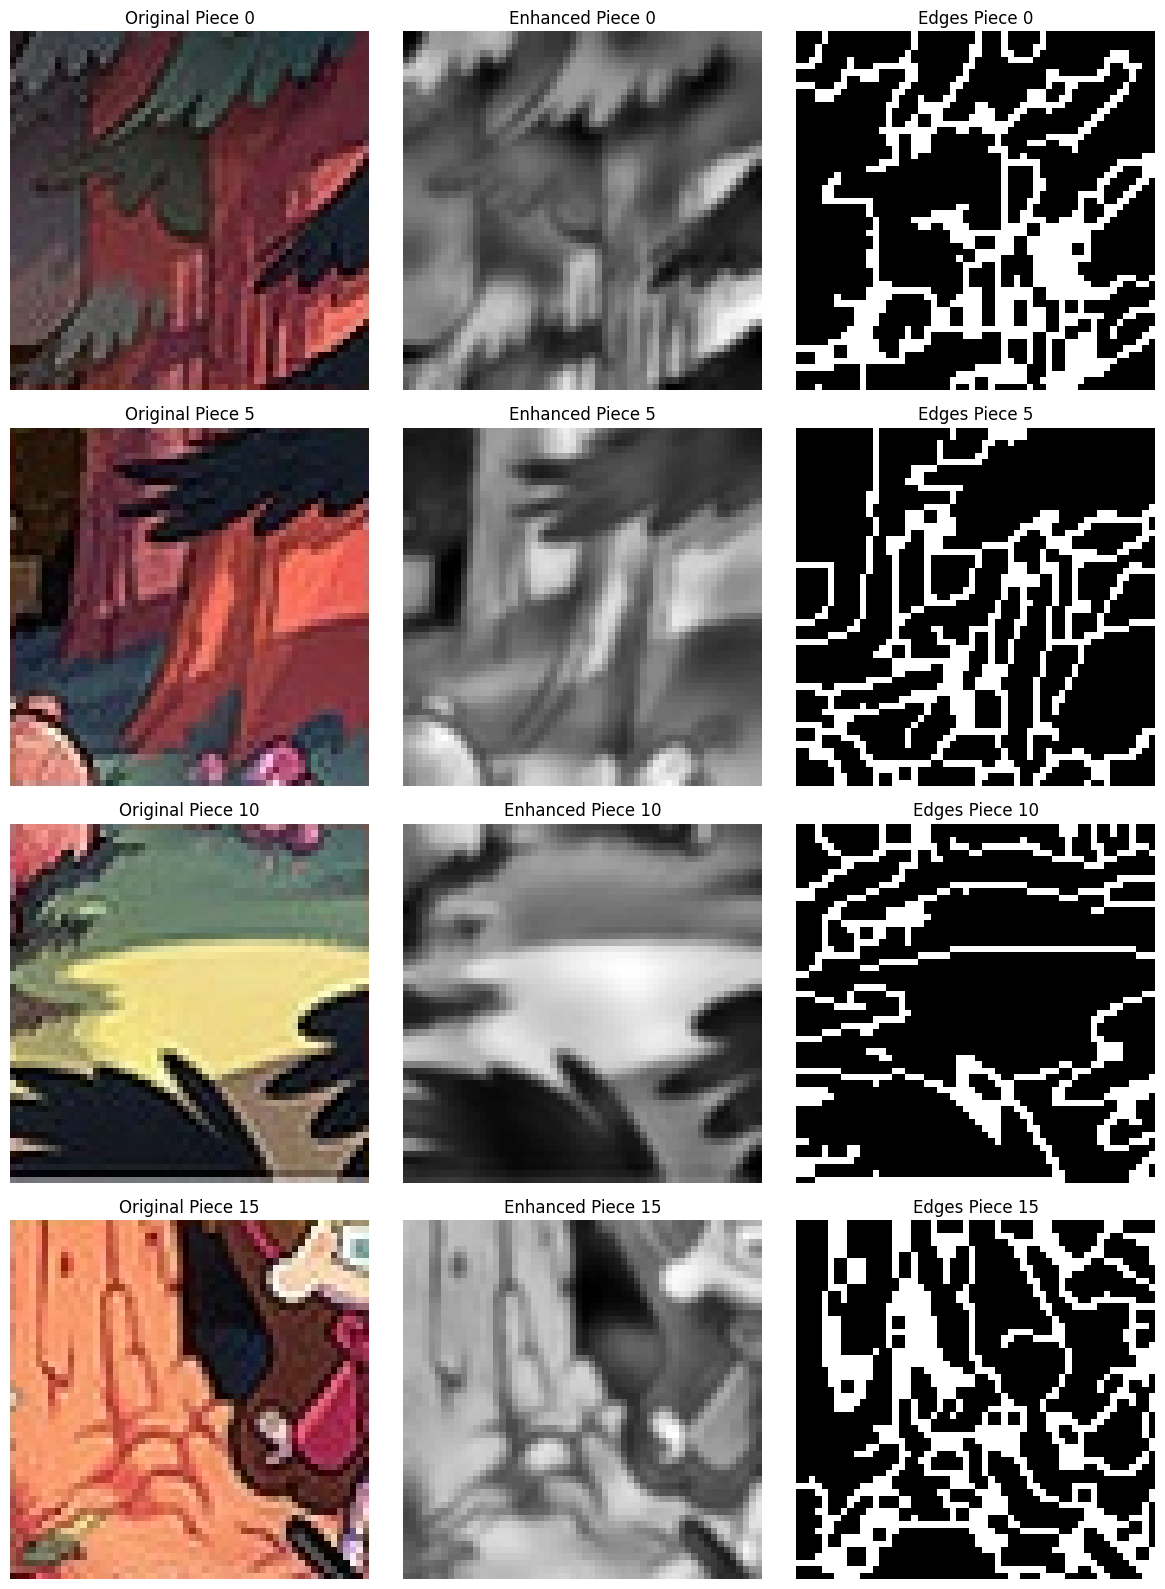

Processing puzzle_4x4/1...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_1
Processing puzzle_4x4/10...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_10
Processing puzzle_4x4/100...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_100
Processing puzzle_4x4/101...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_101
Processing puzzle_4x4/102...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_102
Processing puzzle_4x4/103...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_103
Processing puzzle_4x4/104...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_104
Processing puzzle_4x4/105...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_105
Processing puzzle_4x4/106...
  Split into 16 pieces
  Saved artifacts to ./pro

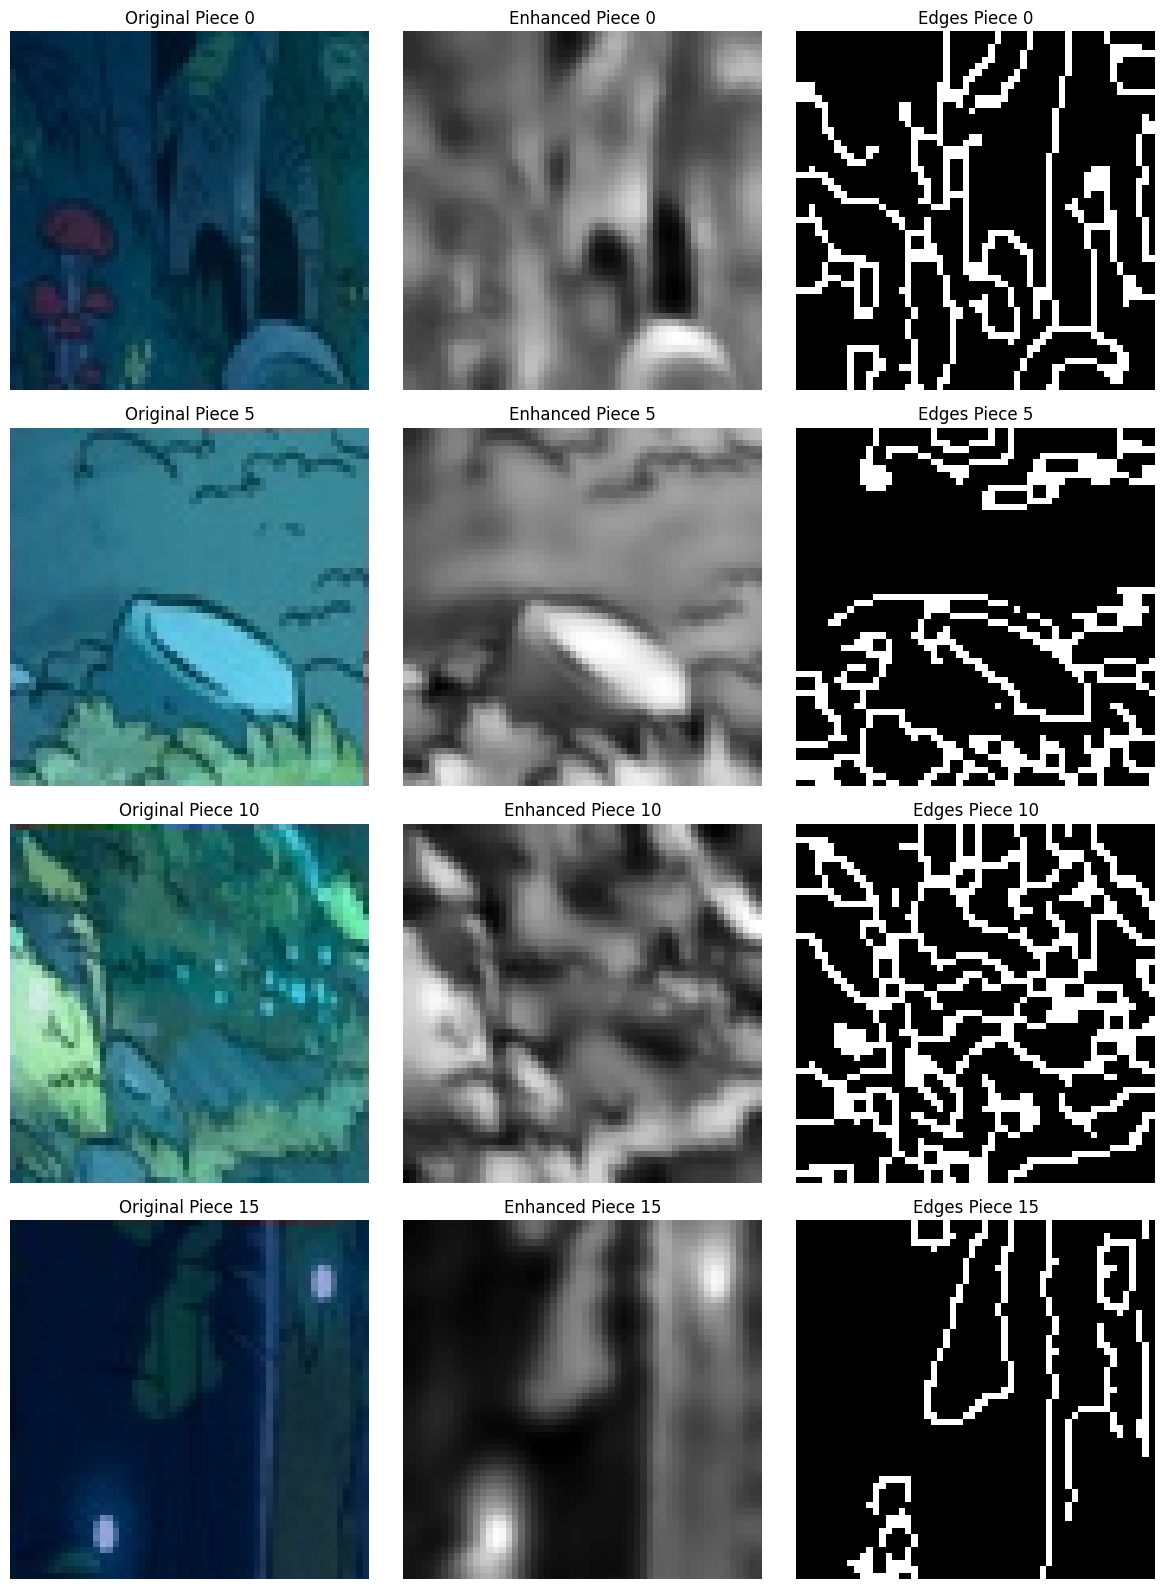

Processing puzzle_4x4/108...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_108
Processing puzzle_4x4/109...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_109
Processing puzzle_4x4/11...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_11
Processing puzzle_4x4/12...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_12
Processing puzzle_4x4/13...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_13
Processing puzzle_4x4/14...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_14
Processing puzzle_4x4/15...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_15
Processing puzzle_4x4/16...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_16
Processing puzzle_4x4/17...
  Split into 16 pieces
  Saved artifacts to ./processed_

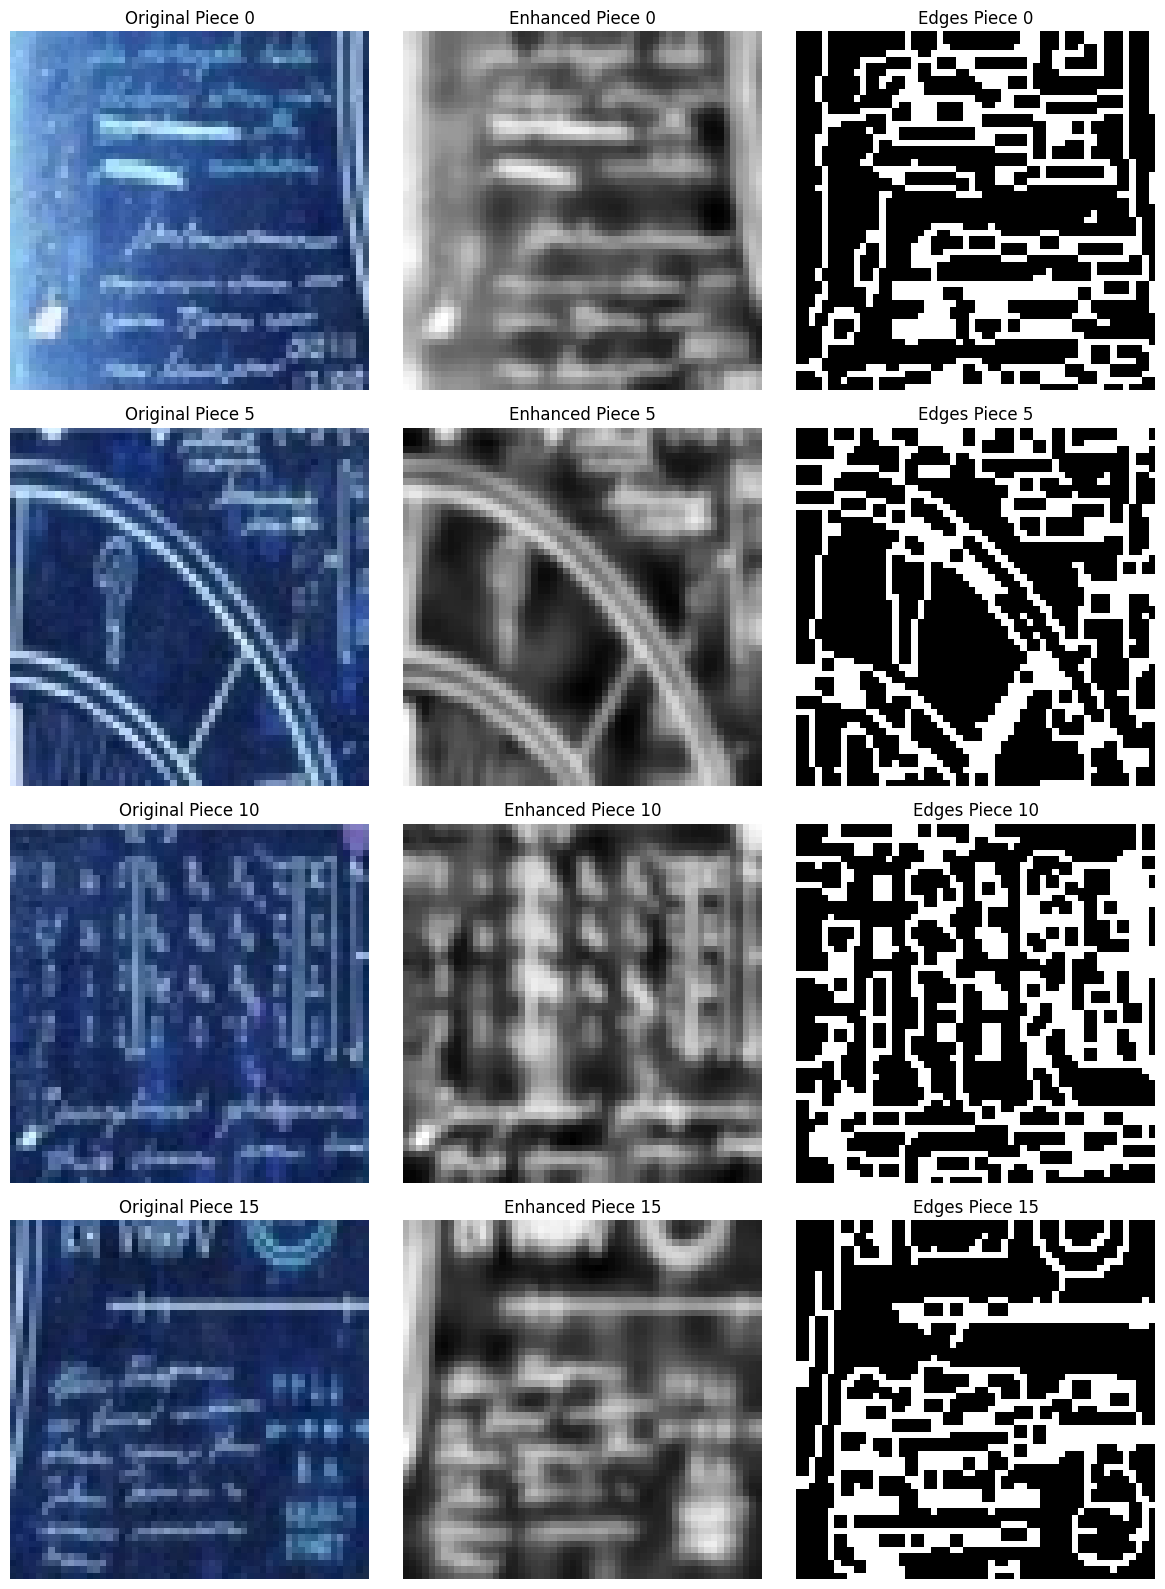

Processing puzzle_4x4/19...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_19
Processing puzzle_4x4/2...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_2
Processing puzzle_4x4/20...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_20
Processing puzzle_4x4/21...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_21
Processing puzzle_4x4/22...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_22
Processing puzzle_4x4/23...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_23
Processing puzzle_4x4/24...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_24
Processing puzzle_4x4/25...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_25
Processing puzzle_4x4/26...
  Split into 16 pieces
  Saved artifacts to ./processed_artifa

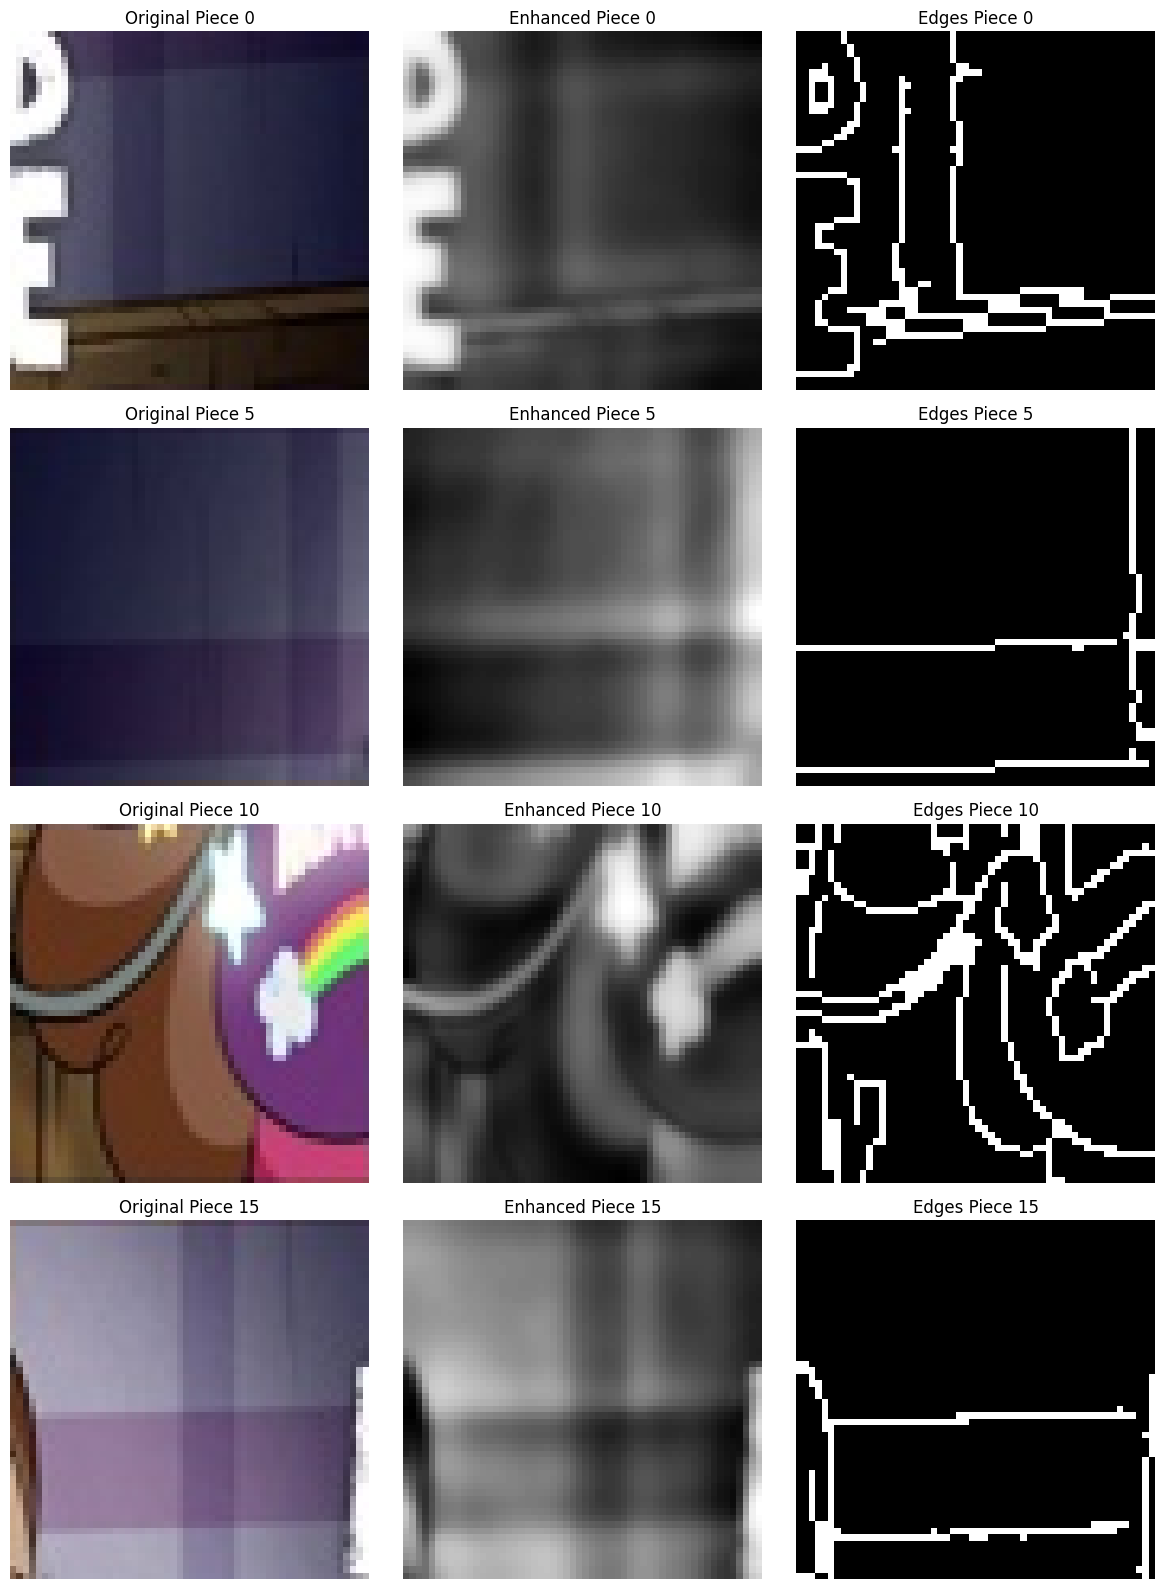

Processing puzzle_4x4/28...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_28
Processing puzzle_4x4/29...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_29
Processing puzzle_4x4/3...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_3
Processing puzzle_4x4/30...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_30
Processing puzzle_4x4/31...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_31
Processing puzzle_4x4/32...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_32
Processing puzzle_4x4/33...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_33
Processing puzzle_4x4/34...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_34
Processing puzzle_4x4/35...
  Split into 16 pieces
  Saved artifacts to ./processed_artifa

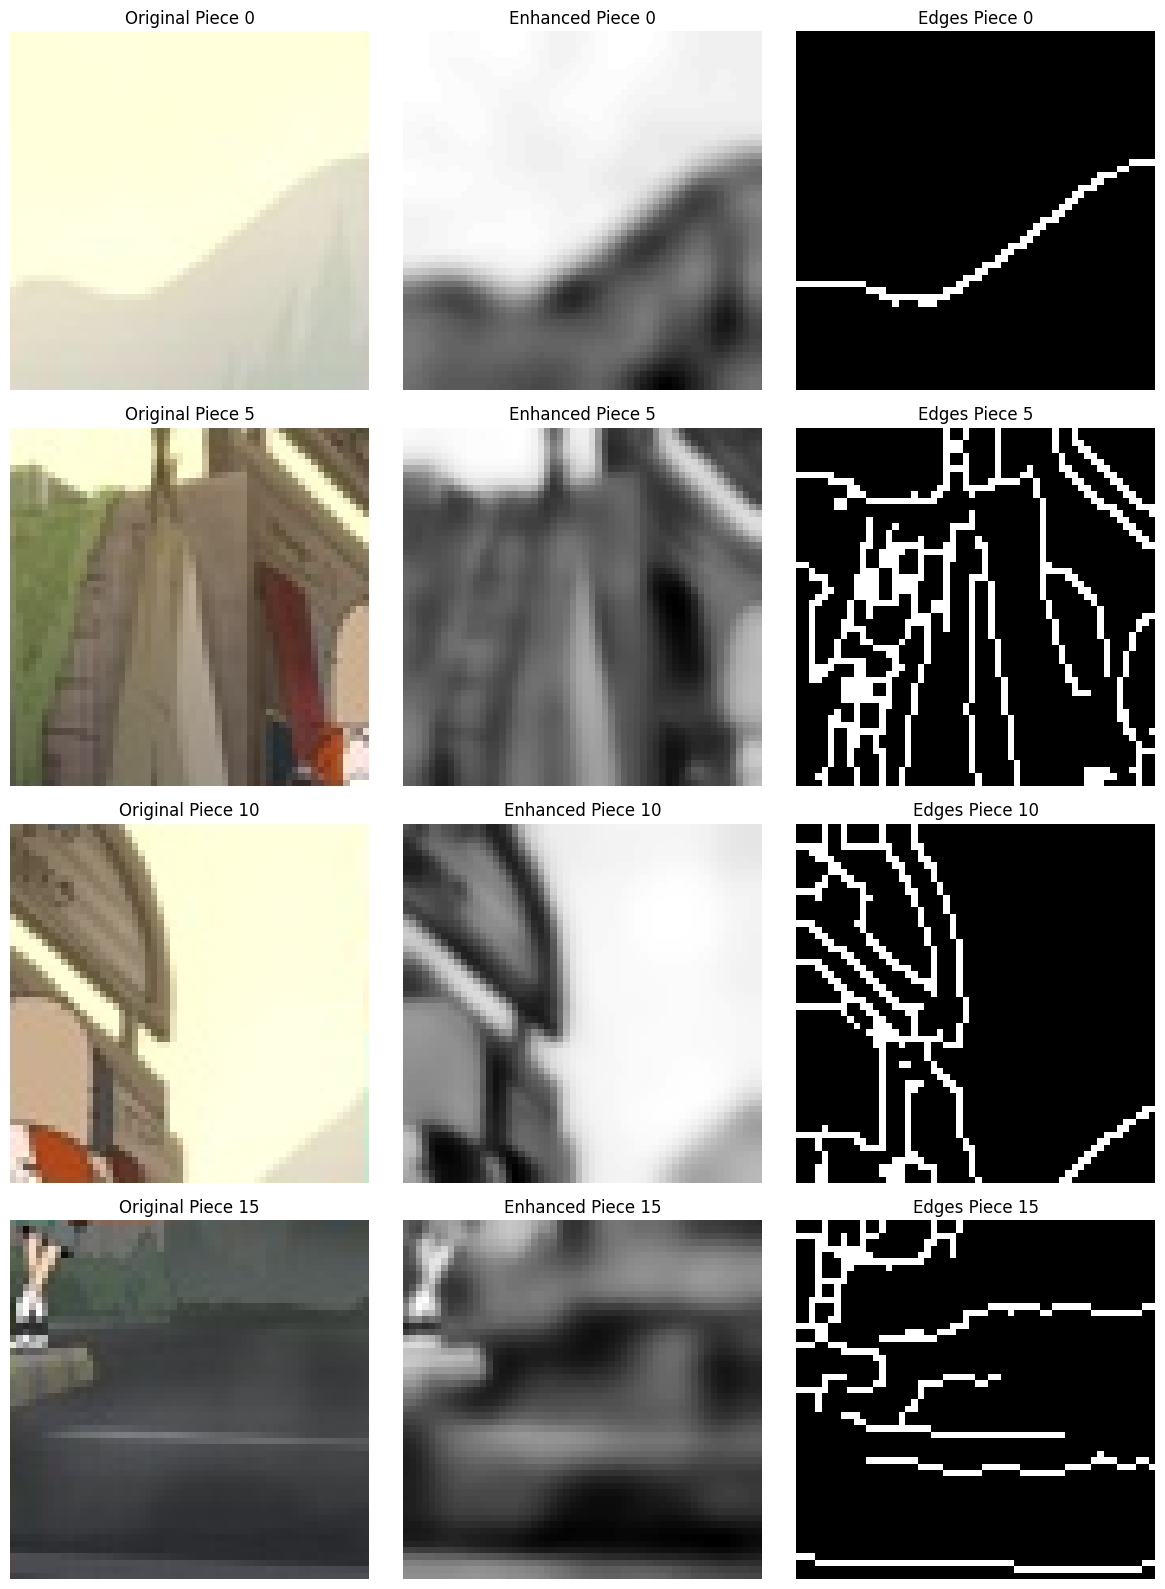

Processing puzzle_4x4/37...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_37
Processing puzzle_4x4/38...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_38
Processing puzzle_4x4/39...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_39
Processing puzzle_4x4/4...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_4
Processing puzzle_4x4/40...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_40
Processing puzzle_4x4/41...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_41
Processing puzzle_4x4/42...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_42
Processing puzzle_4x4/43...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_43
Processing puzzle_4x4/44...
  Split into 16 pieces
  Saved artifacts to ./processed_artifa

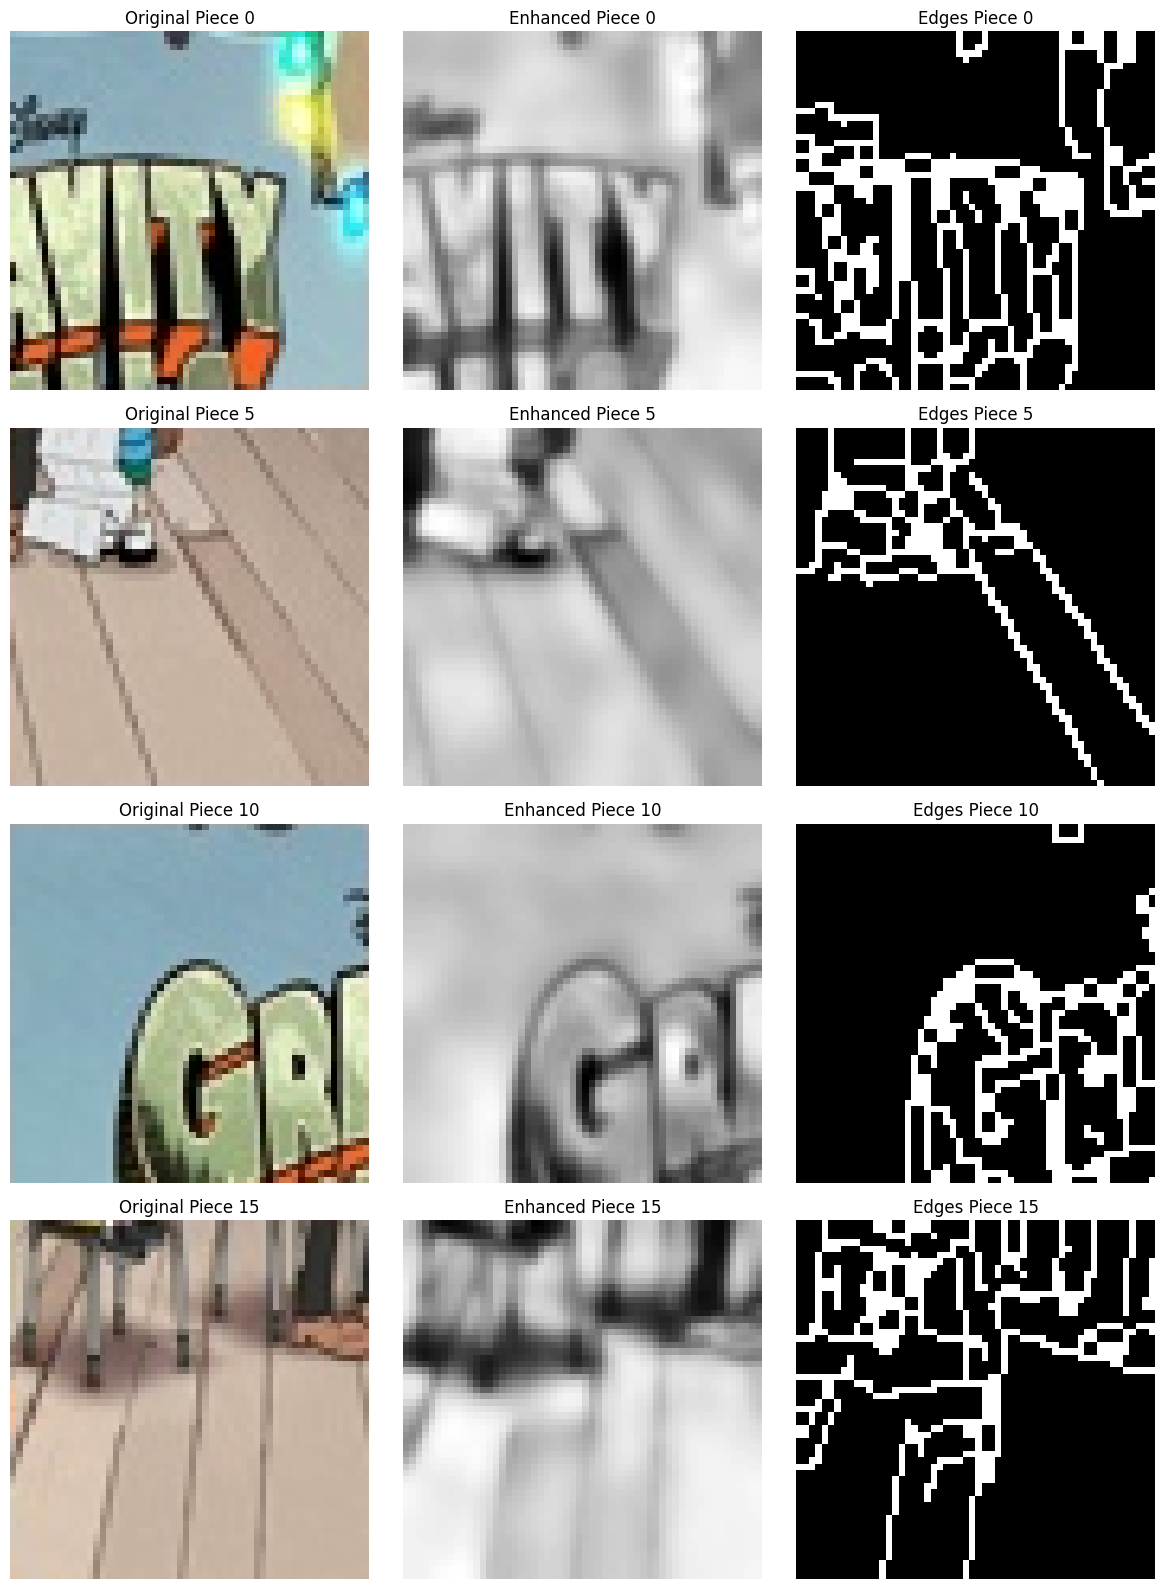

Processing puzzle_4x4/46...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_46
Processing puzzle_4x4/47...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_47
Processing puzzle_4x4/48...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_48
Processing puzzle_4x4/49...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_49
Processing puzzle_4x4/5...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_5
Processing puzzle_4x4/50...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_50
Processing puzzle_4x4/51...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_51
Processing puzzle_4x4/52...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_52
Processing puzzle_4x4/53...
  Split into 16 pieces
  Saved artifacts to ./processed_artifa

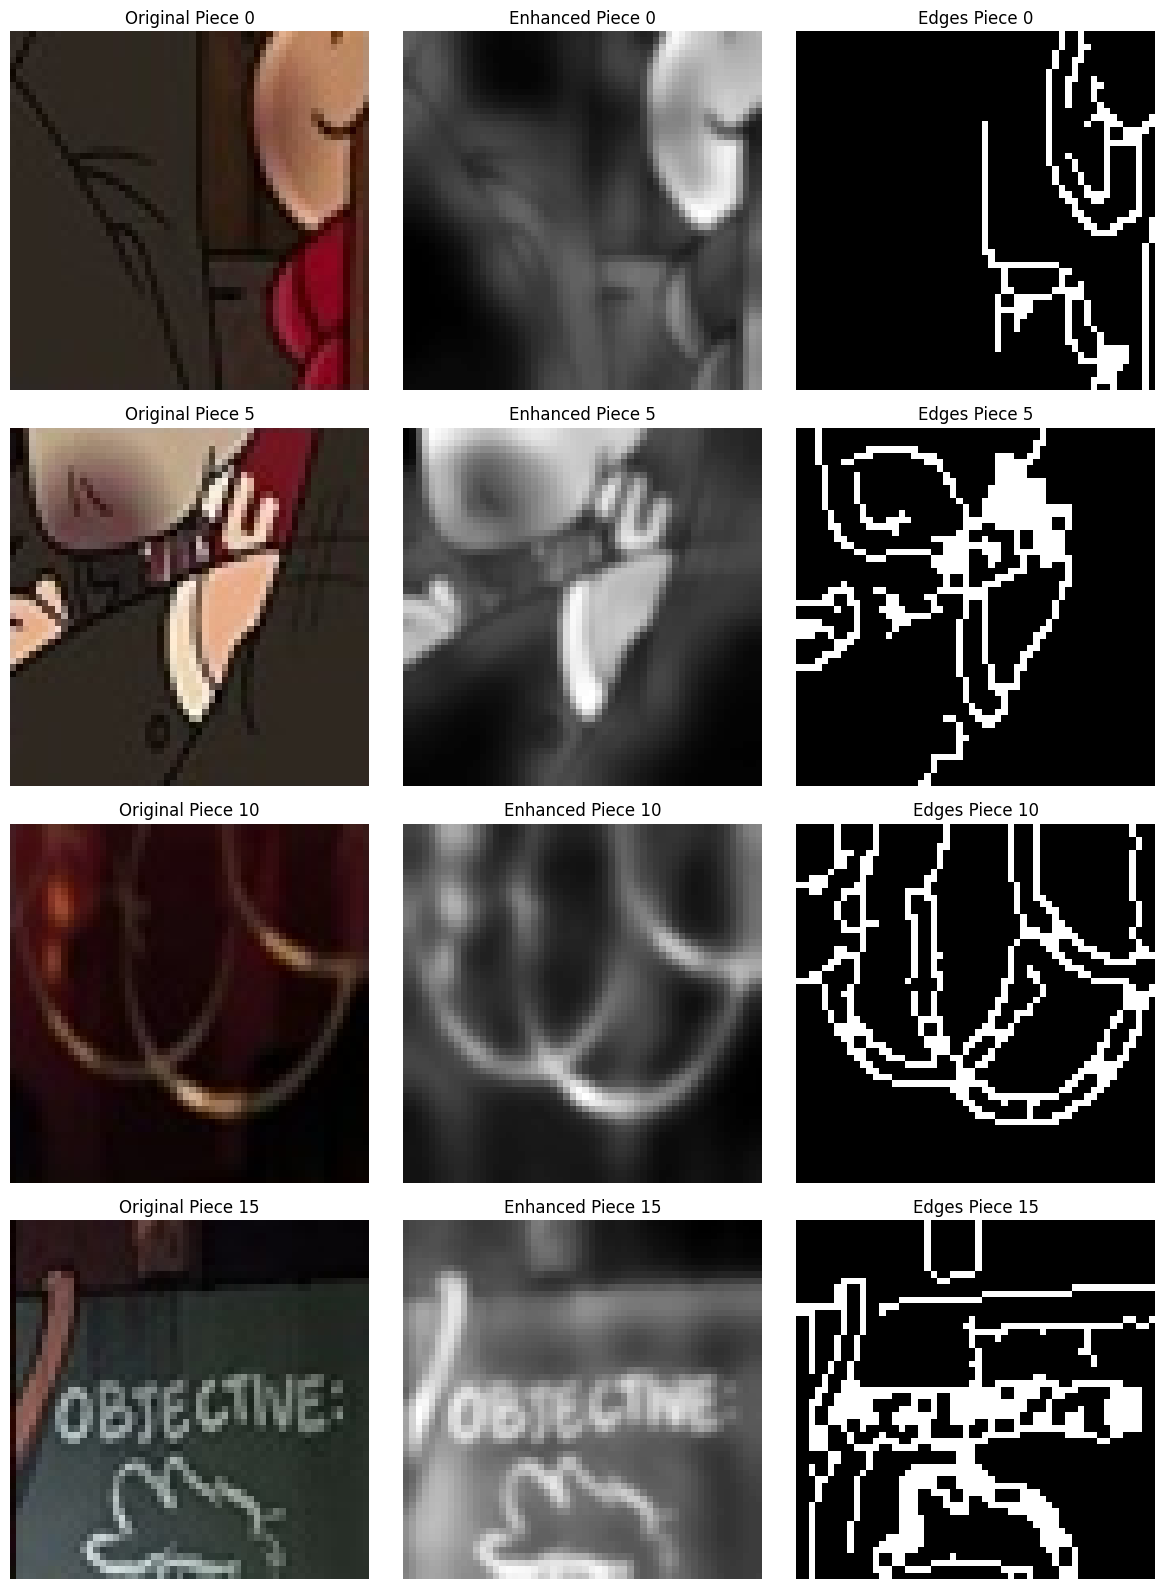

Processing puzzle_4x4/55...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_55
Processing puzzle_4x4/56...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_56
Processing puzzle_4x4/57...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_57
Processing puzzle_4x4/58...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_58
Processing puzzle_4x4/59...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_59
Processing puzzle_4x4/6...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_6
Processing puzzle_4x4/60...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_60
Processing puzzle_4x4/61...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_61
Processing puzzle_4x4/62...
  Split into 16 pieces
  Saved artifacts to ./processed_artifa

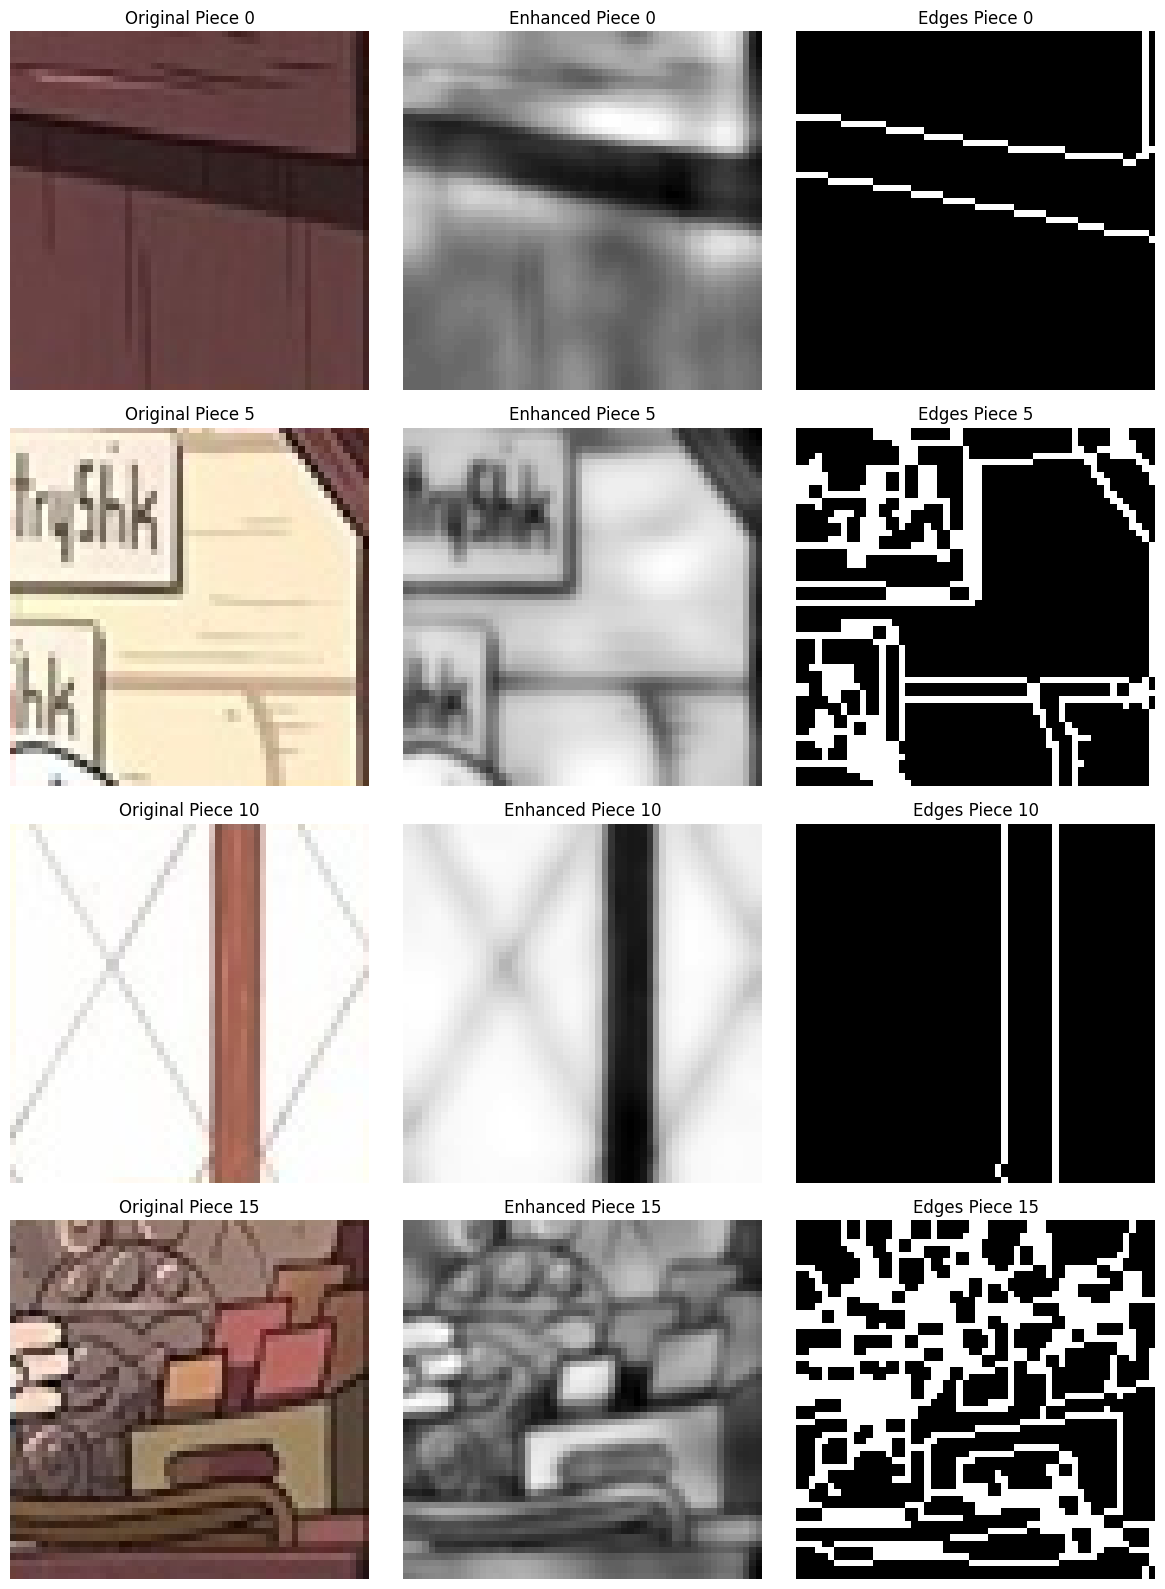

Processing puzzle_4x4/64...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_64
Processing puzzle_4x4/65...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_65
Processing puzzle_4x4/66...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_66
Processing puzzle_4x4/67...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_67
Processing puzzle_4x4/68...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_68
Processing puzzle_4x4/69...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_69
Processing puzzle_4x4/7...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_7
Processing puzzle_4x4/70...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_70
Processing puzzle_4x4/71...
  Split into 16 pieces
  Saved artifacts to ./processed_artifa

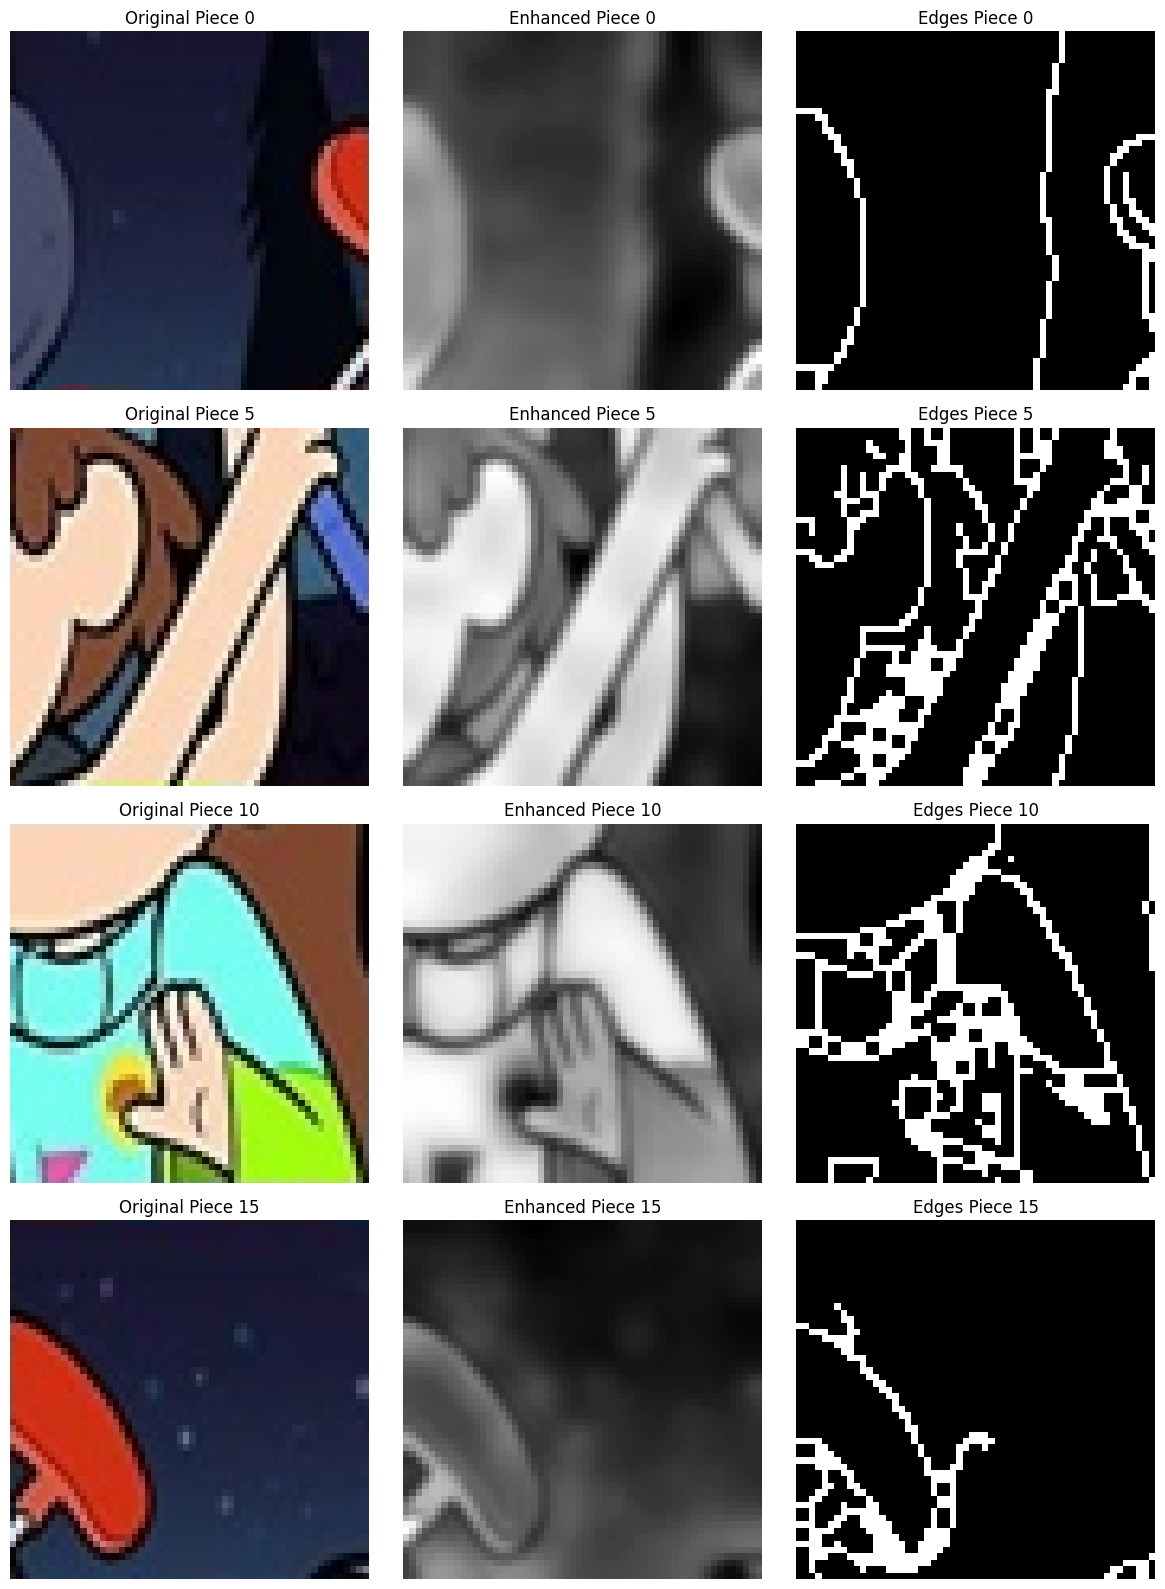

Processing puzzle_4x4/73...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_73
Processing puzzle_4x4/74...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_74
Processing puzzle_4x4/75...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_75
Processing puzzle_4x4/76...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_76
Processing puzzle_4x4/77...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_77
Processing puzzle_4x4/78...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_78
Processing puzzle_4x4/79...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_79
Processing puzzle_4x4/8...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_8
Processing puzzle_4x4/80...
  Split into 16 pieces
  Saved artifacts to ./processed_artifa

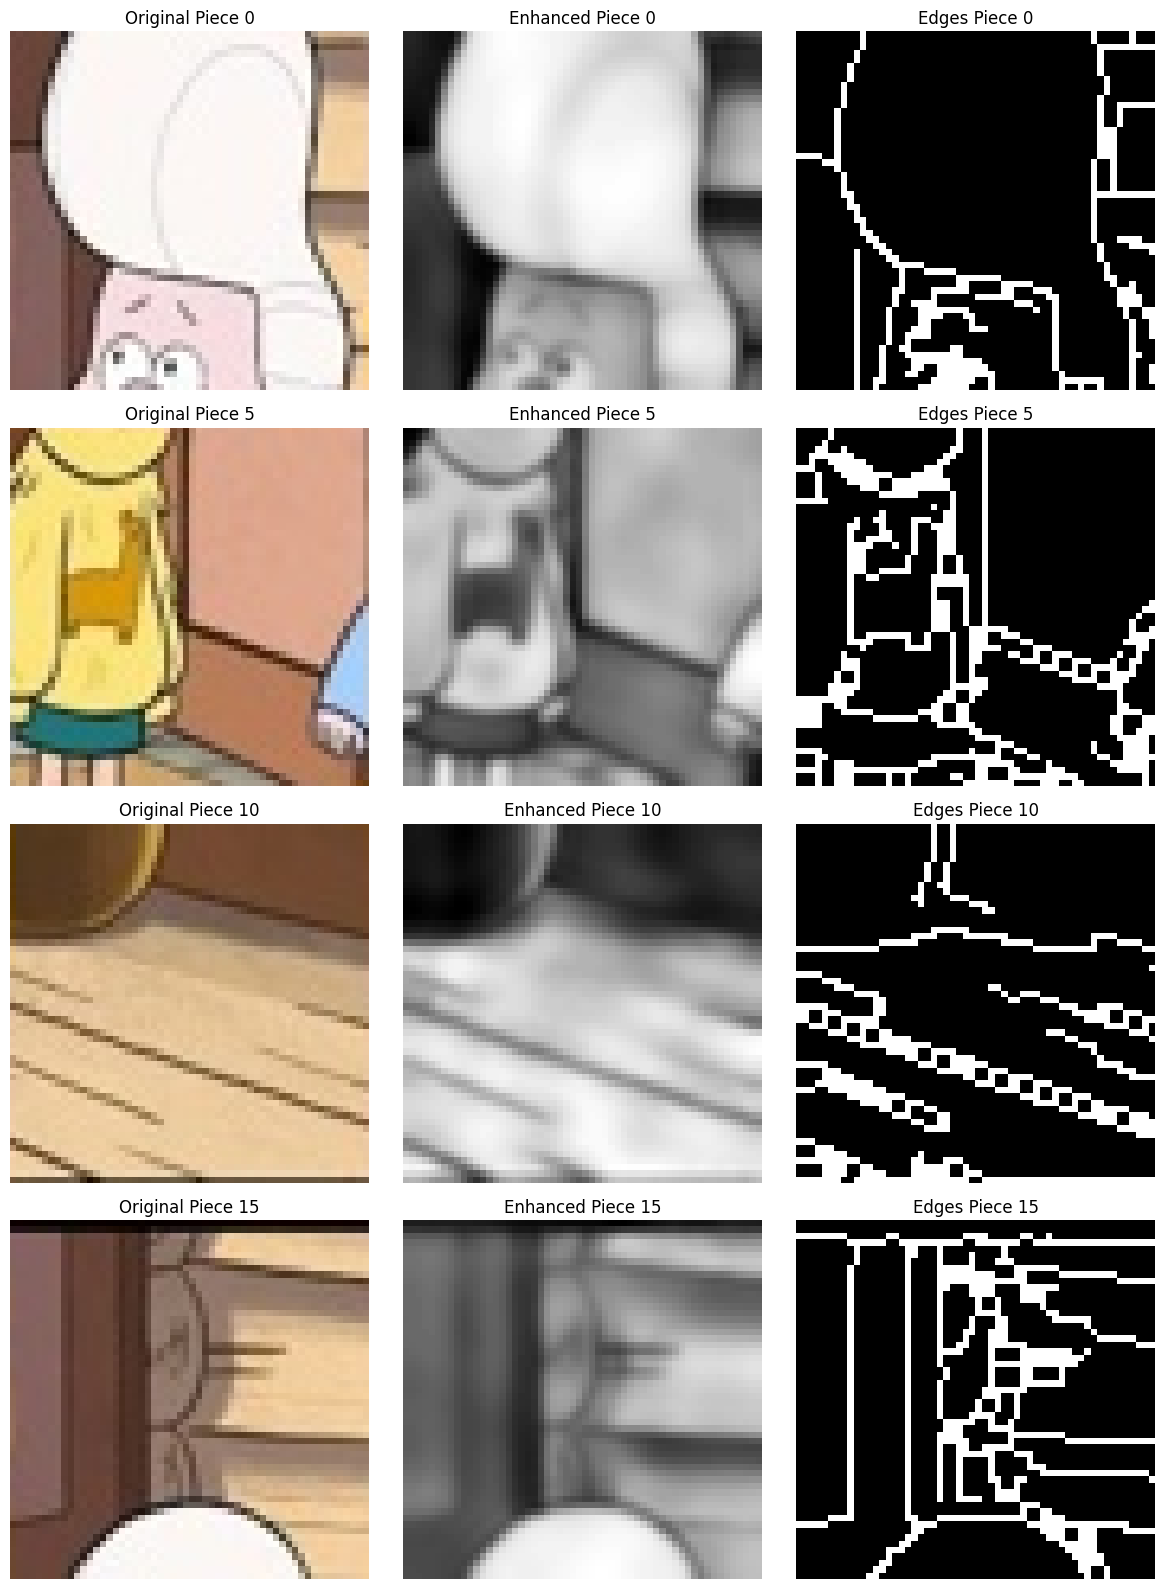

Processing puzzle_4x4/82...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_82
Processing puzzle_4x4/83...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_83
Processing puzzle_4x4/84...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_84
Processing puzzle_4x4/85...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_85
Processing puzzle_4x4/86...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_86
Processing puzzle_4x4/87...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_87
Processing puzzle_4x4/88...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_88
Processing puzzle_4x4/89...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_89
Processing puzzle_4x4/9...
  Split into 16 pieces
  Saved artifacts to ./processed_artif

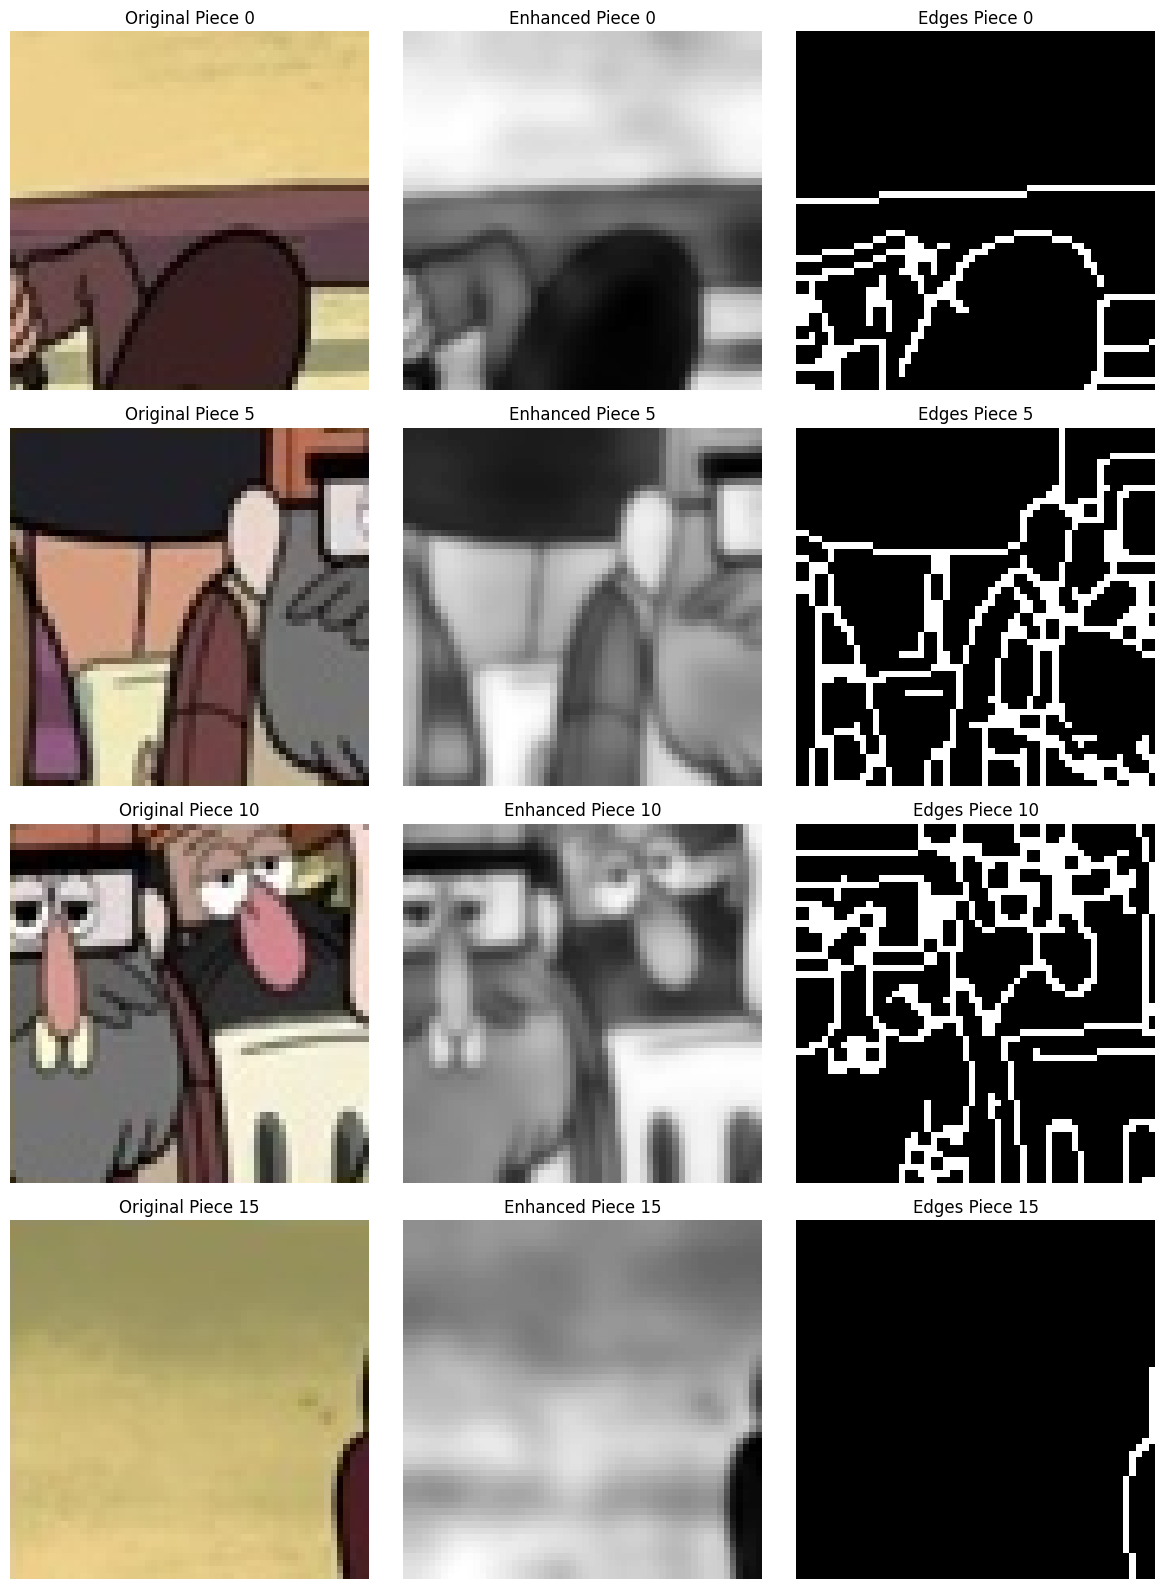

Processing puzzle_4x4/91...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_91
Processing puzzle_4x4/92...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_92
Processing puzzle_4x4/93...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_93
Processing puzzle_4x4/94...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_94
Processing puzzle_4x4/95...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_95
Processing puzzle_4x4/96...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_96
Processing puzzle_4x4/97...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_97
Processing puzzle_4x4/98...
  Split into 16 pieces
  Saved artifacts to ./processed_artifacts\puzzle_4x4\image_98
Processing puzzle_4x4/99...
  Split into 16 pieces
  Saved artifacts to ./processed_arti

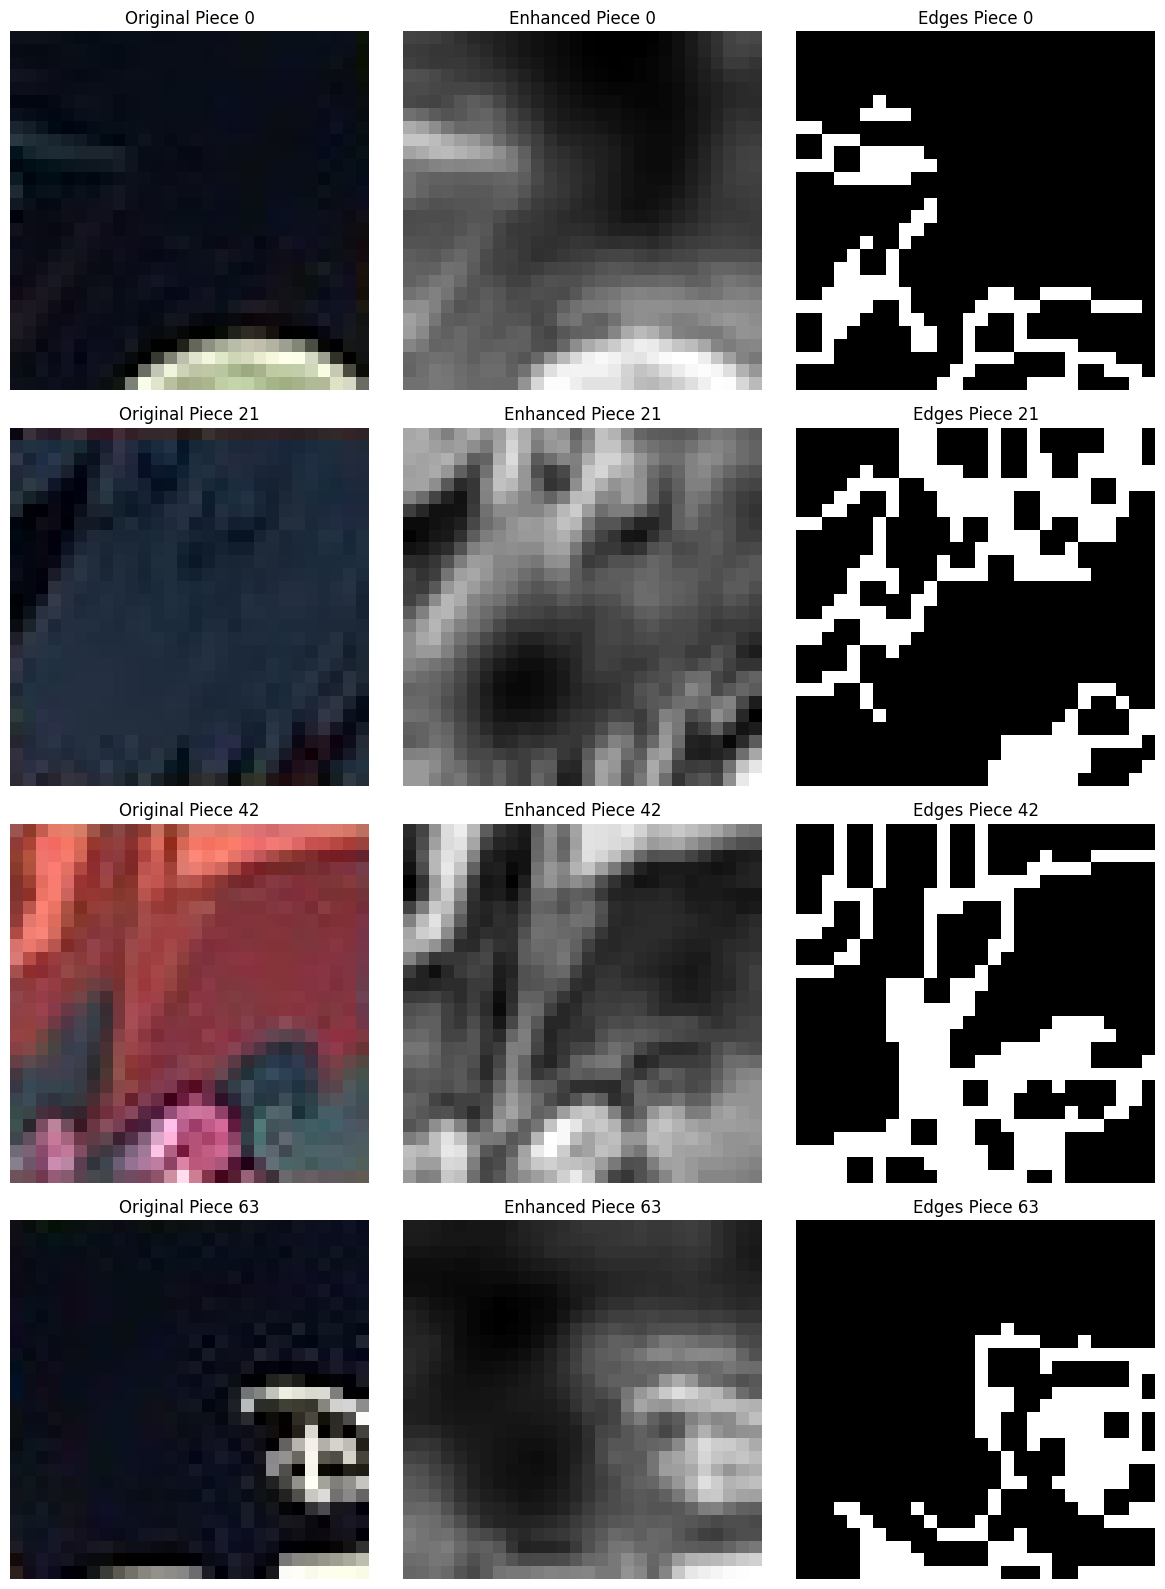

Processing puzzle_8x8/1...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_1
Processing puzzle_8x8/10...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_10
Processing puzzle_8x8/100...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_100
Processing puzzle_8x8/101...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_101
Processing puzzle_8x8/102...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_102
Processing puzzle_8x8/103...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_103
Processing puzzle_8x8/104...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_104
Processing puzzle_8x8/105...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_105
Processing puzzle_8x8/106...
  Split into 64 pieces
  Saved artifacts to ./pro

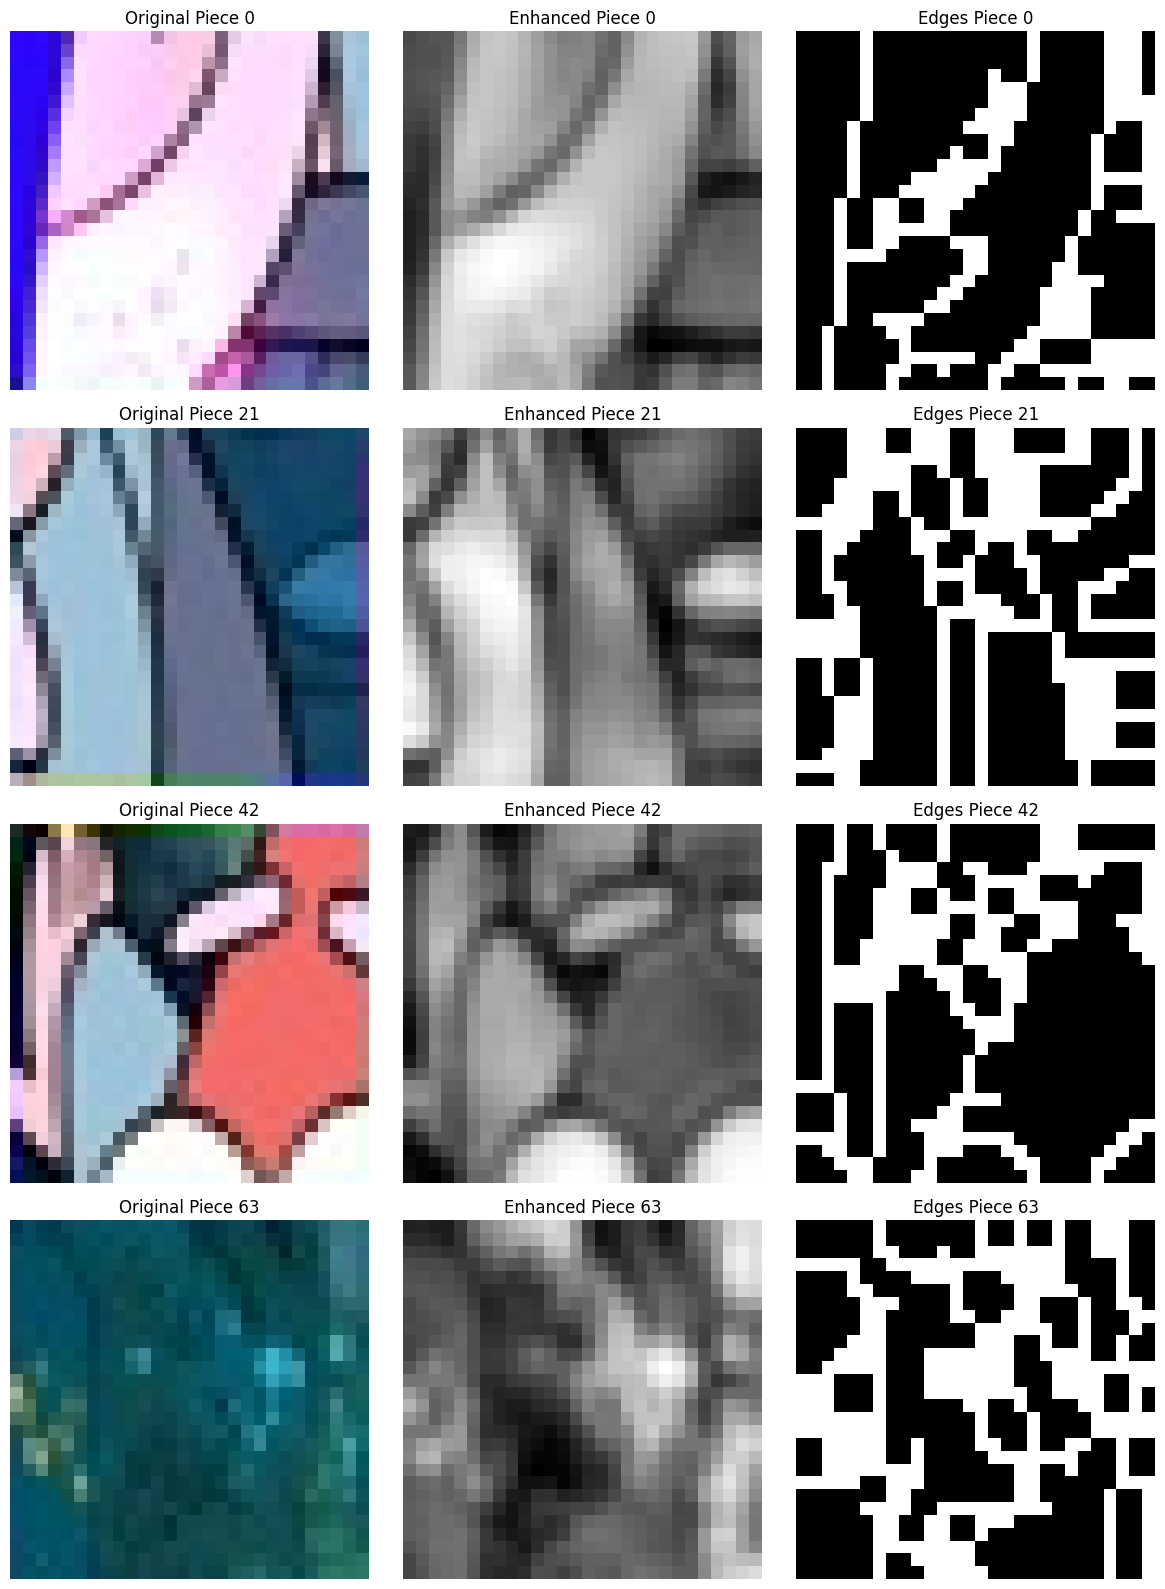

Processing puzzle_8x8/108...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_108
Processing puzzle_8x8/109...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_109
Processing puzzle_8x8/11...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_11
Processing puzzle_8x8/12...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_12
Processing puzzle_8x8/13...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_13
Processing puzzle_8x8/14...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_14
Processing puzzle_8x8/15...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_15
Processing puzzle_8x8/16...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_16
Processing puzzle_8x8/17...
  Split into 64 pieces
  Saved artifacts to ./processed_

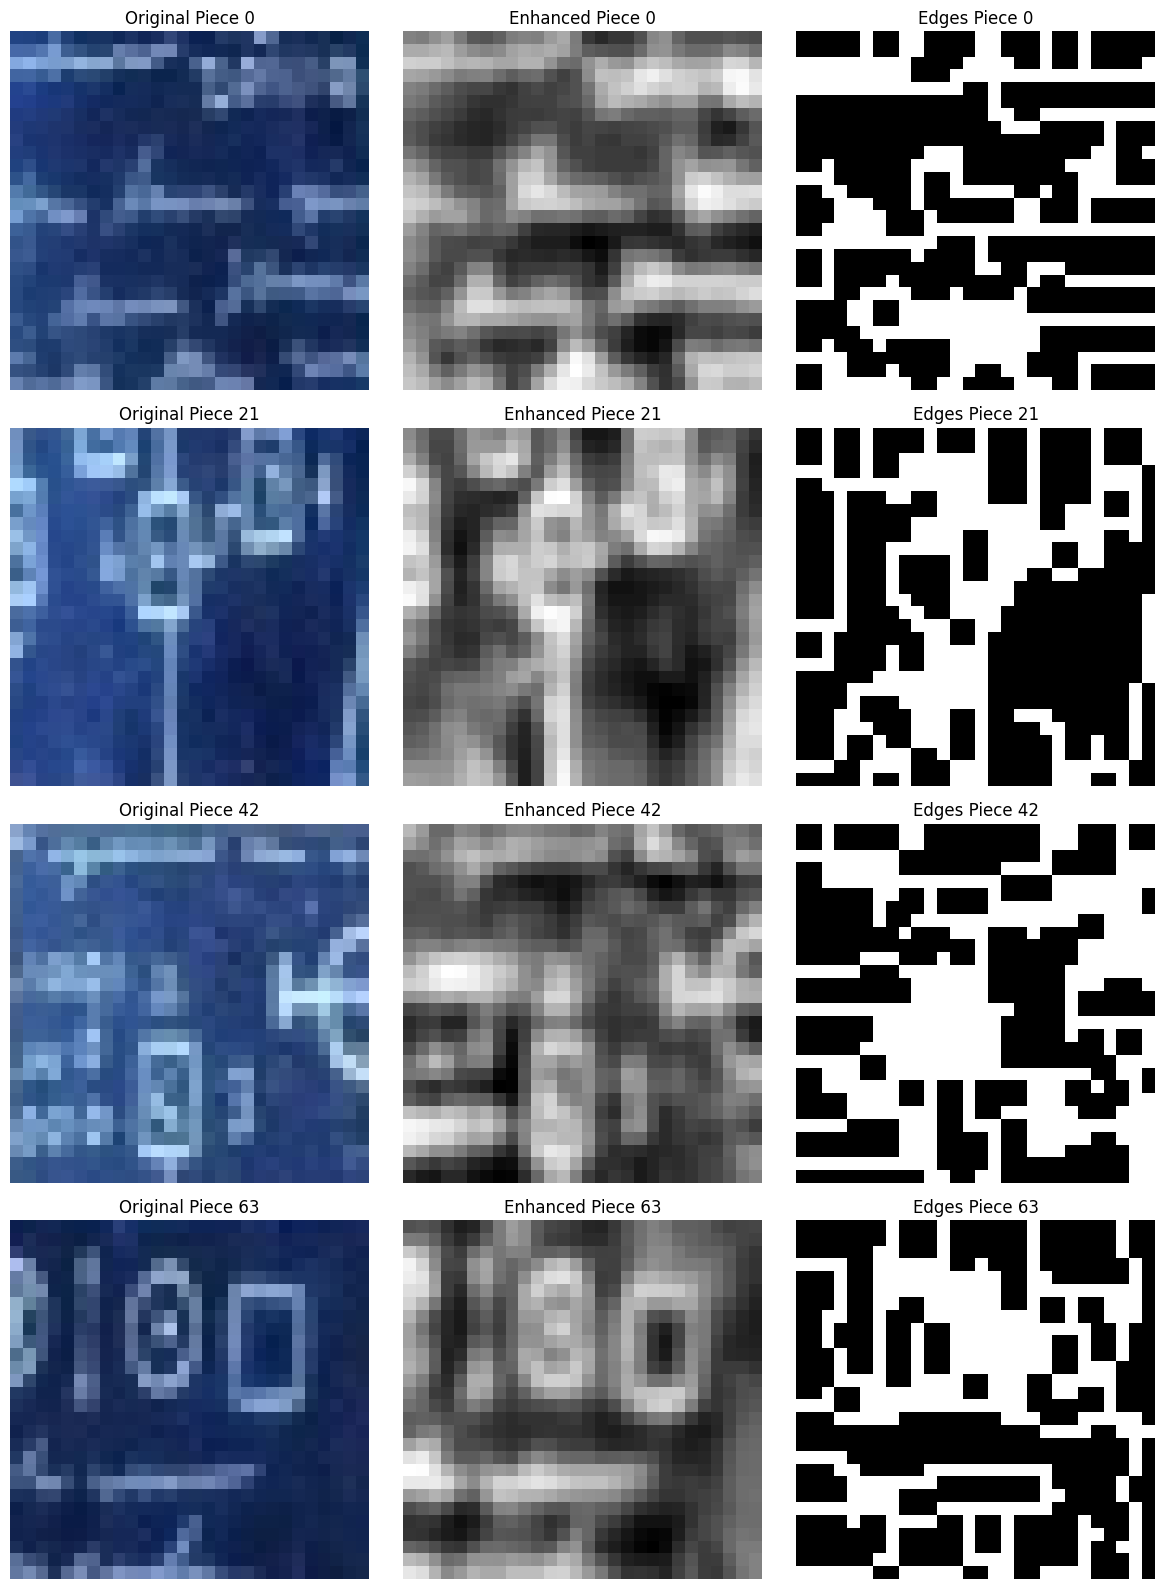

Processing puzzle_8x8/19...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_19
Processing puzzle_8x8/2...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_2
Processing puzzle_8x8/20...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_20
Processing puzzle_8x8/21...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_21
Processing puzzle_8x8/22...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_22
Processing puzzle_8x8/23...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_23
Processing puzzle_8x8/24...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_24
Processing puzzle_8x8/25...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_25
Processing puzzle_8x8/26...
  Split into 64 pieces
  Saved artifacts to ./processed_artifa

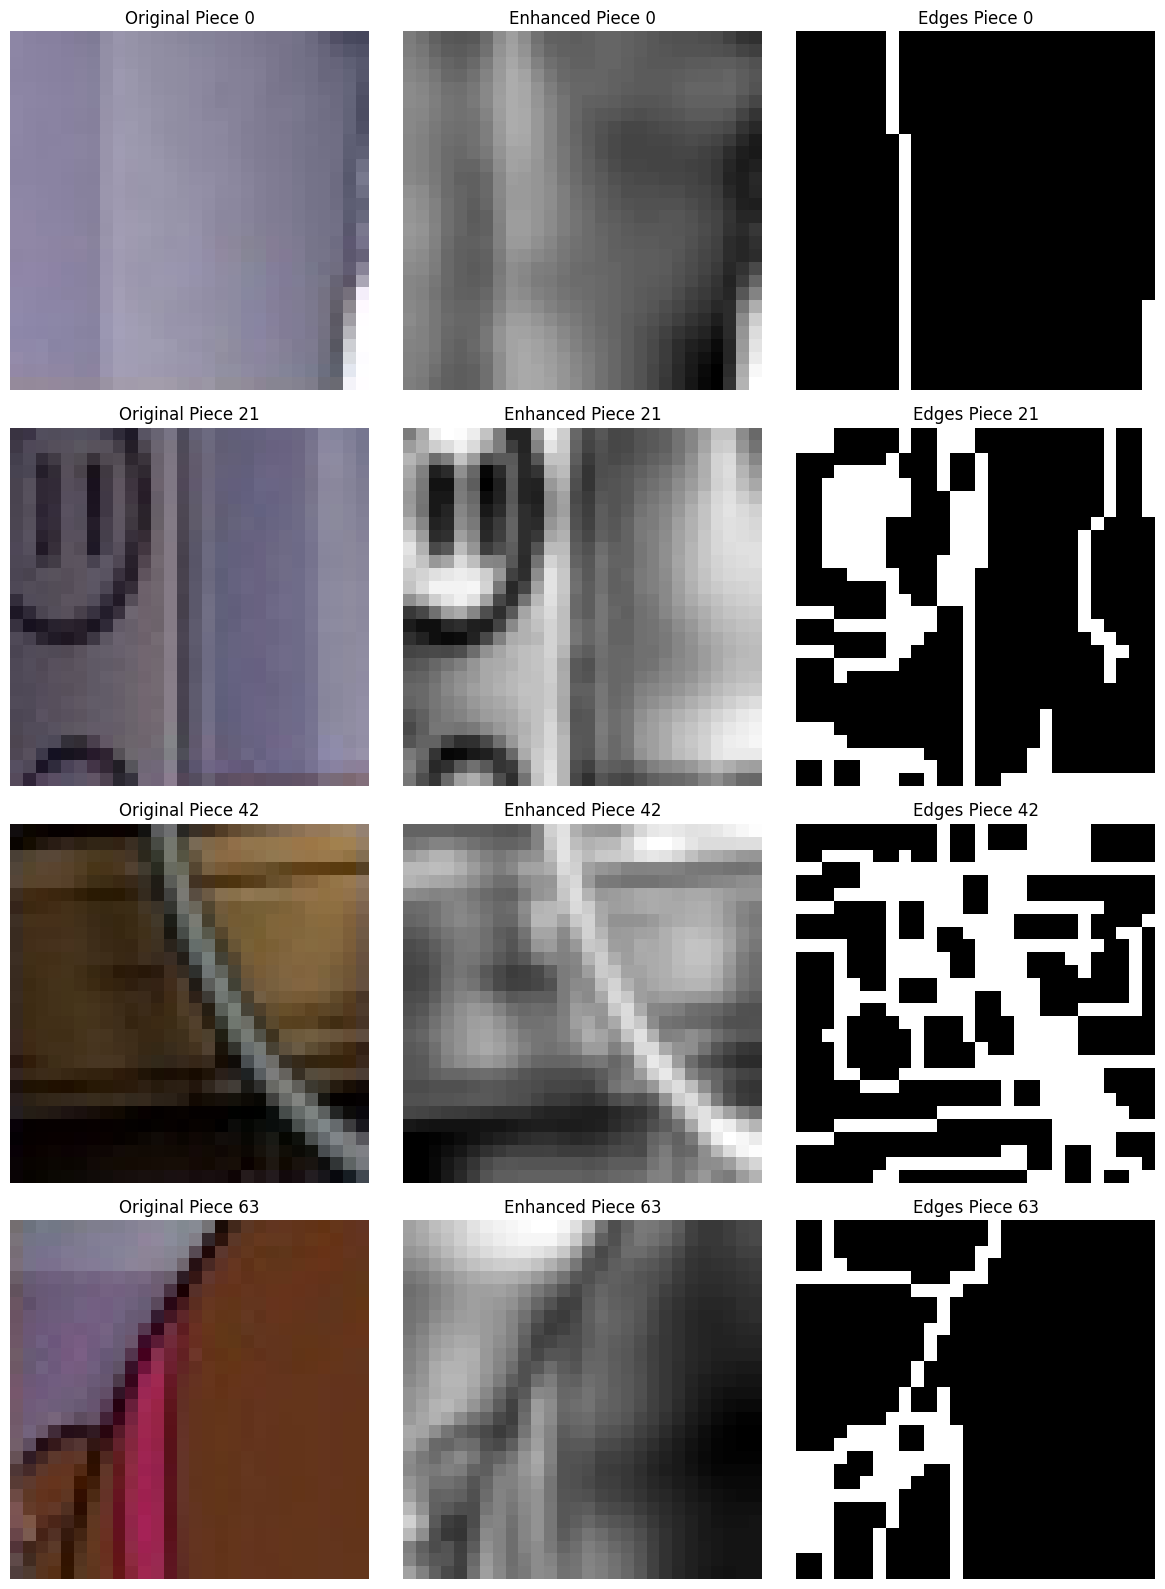

Processing puzzle_8x8/28...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_28
Processing puzzle_8x8/29...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_29
Processing puzzle_8x8/3...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_3
Processing puzzle_8x8/30...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_30
Processing puzzle_8x8/31...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_31
Processing puzzle_8x8/32...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_32
Processing puzzle_8x8/33...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_33
Processing puzzle_8x8/34...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_34
Processing puzzle_8x8/35...
  Split into 64 pieces
  Saved artifacts to ./processed_artifa

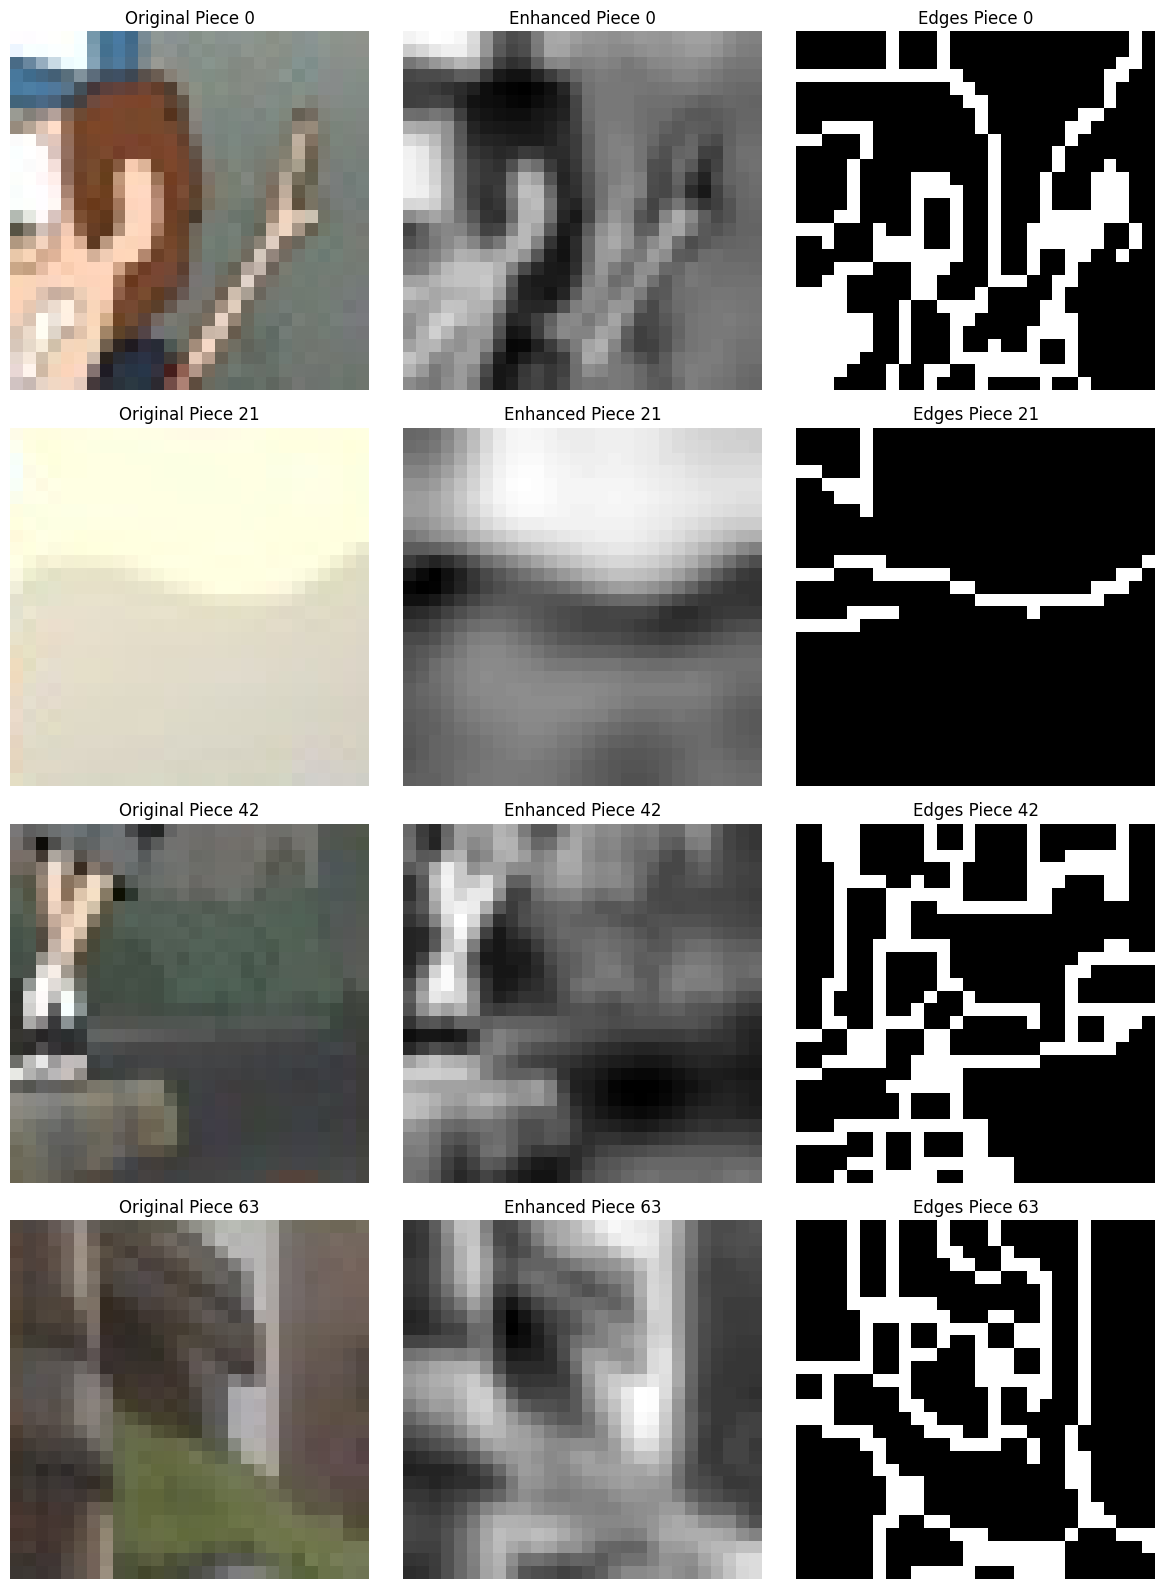

Processing puzzle_8x8/37...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_37
Processing puzzle_8x8/38...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_38
Processing puzzle_8x8/39...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_39
Processing puzzle_8x8/4...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_4
Processing puzzle_8x8/40...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_40
Processing puzzle_8x8/41...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_41
Processing puzzle_8x8/42...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_42
Processing puzzle_8x8/43...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_43
Processing puzzle_8x8/44...
  Split into 64 pieces
  Saved artifacts to ./processed_artifa

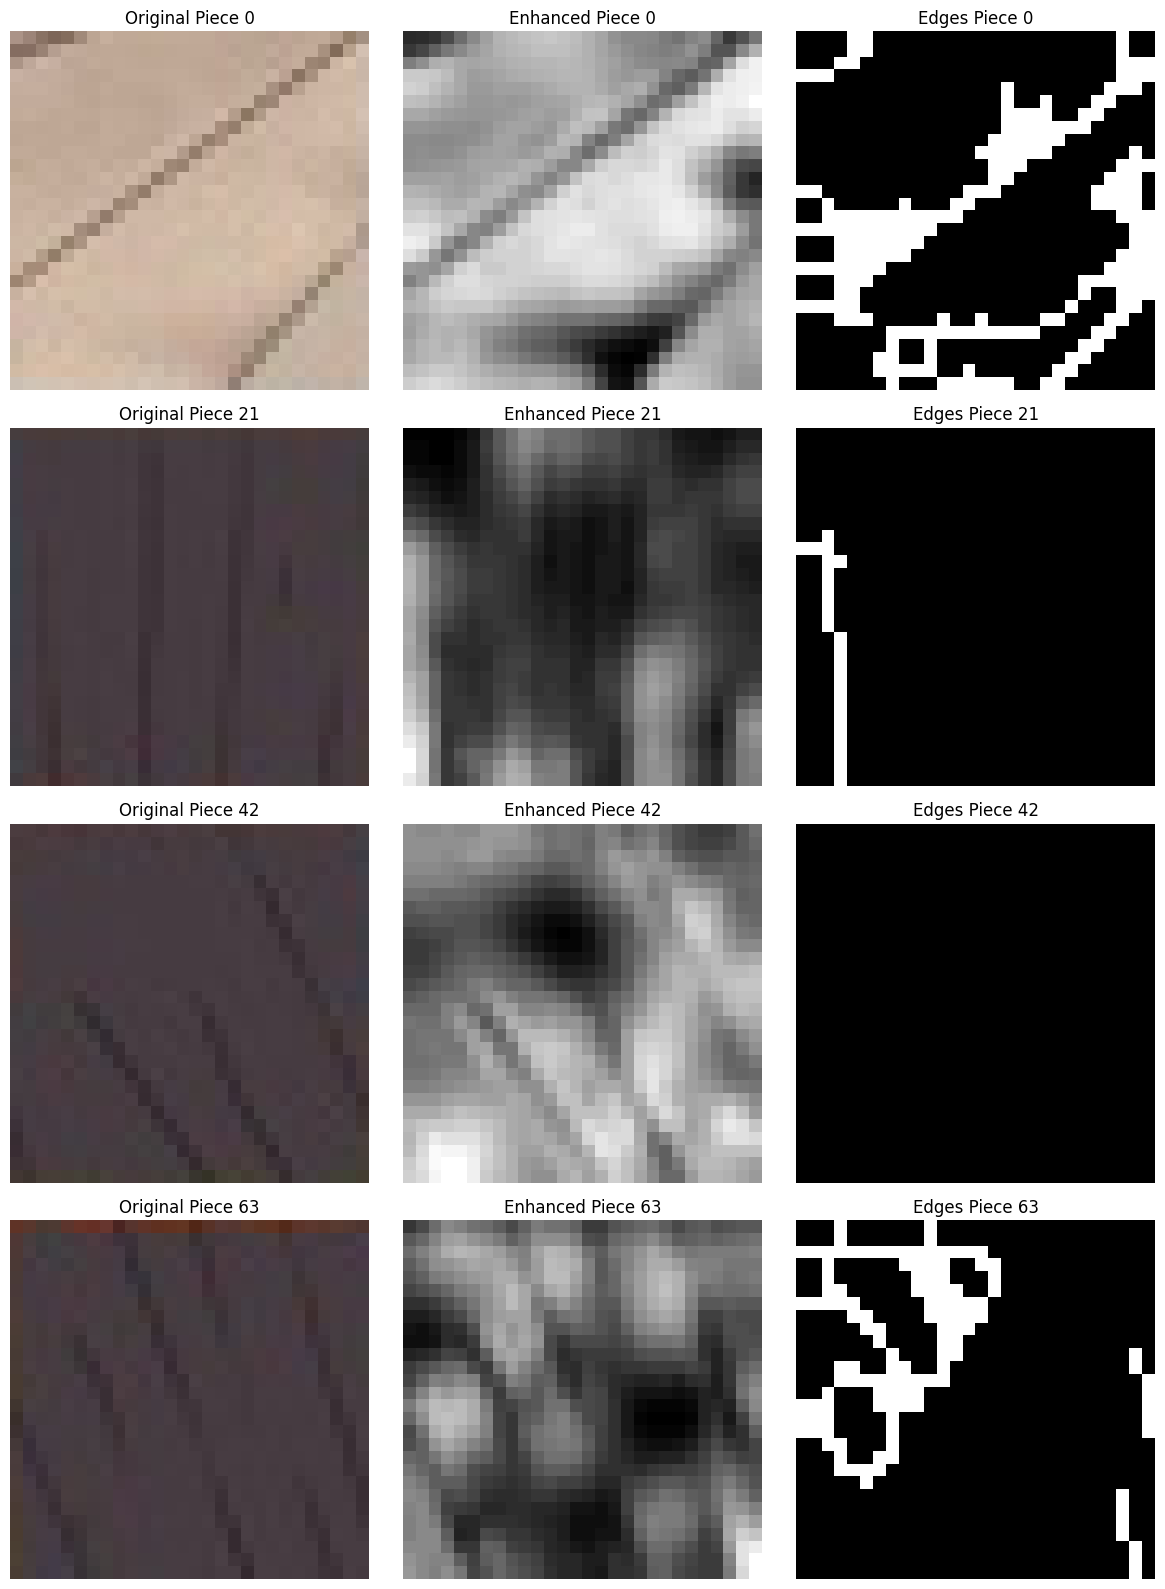

Processing puzzle_8x8/46...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_46
Processing puzzle_8x8/47...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_47
Processing puzzle_8x8/48...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_48
Processing puzzle_8x8/49...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_49
Processing puzzle_8x8/5...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_5
Processing puzzle_8x8/50...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_50
Processing puzzle_8x8/51...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_51
Processing puzzle_8x8/52...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_52
Processing puzzle_8x8/53...
  Split into 64 pieces
  Saved artifacts to ./processed_artifa

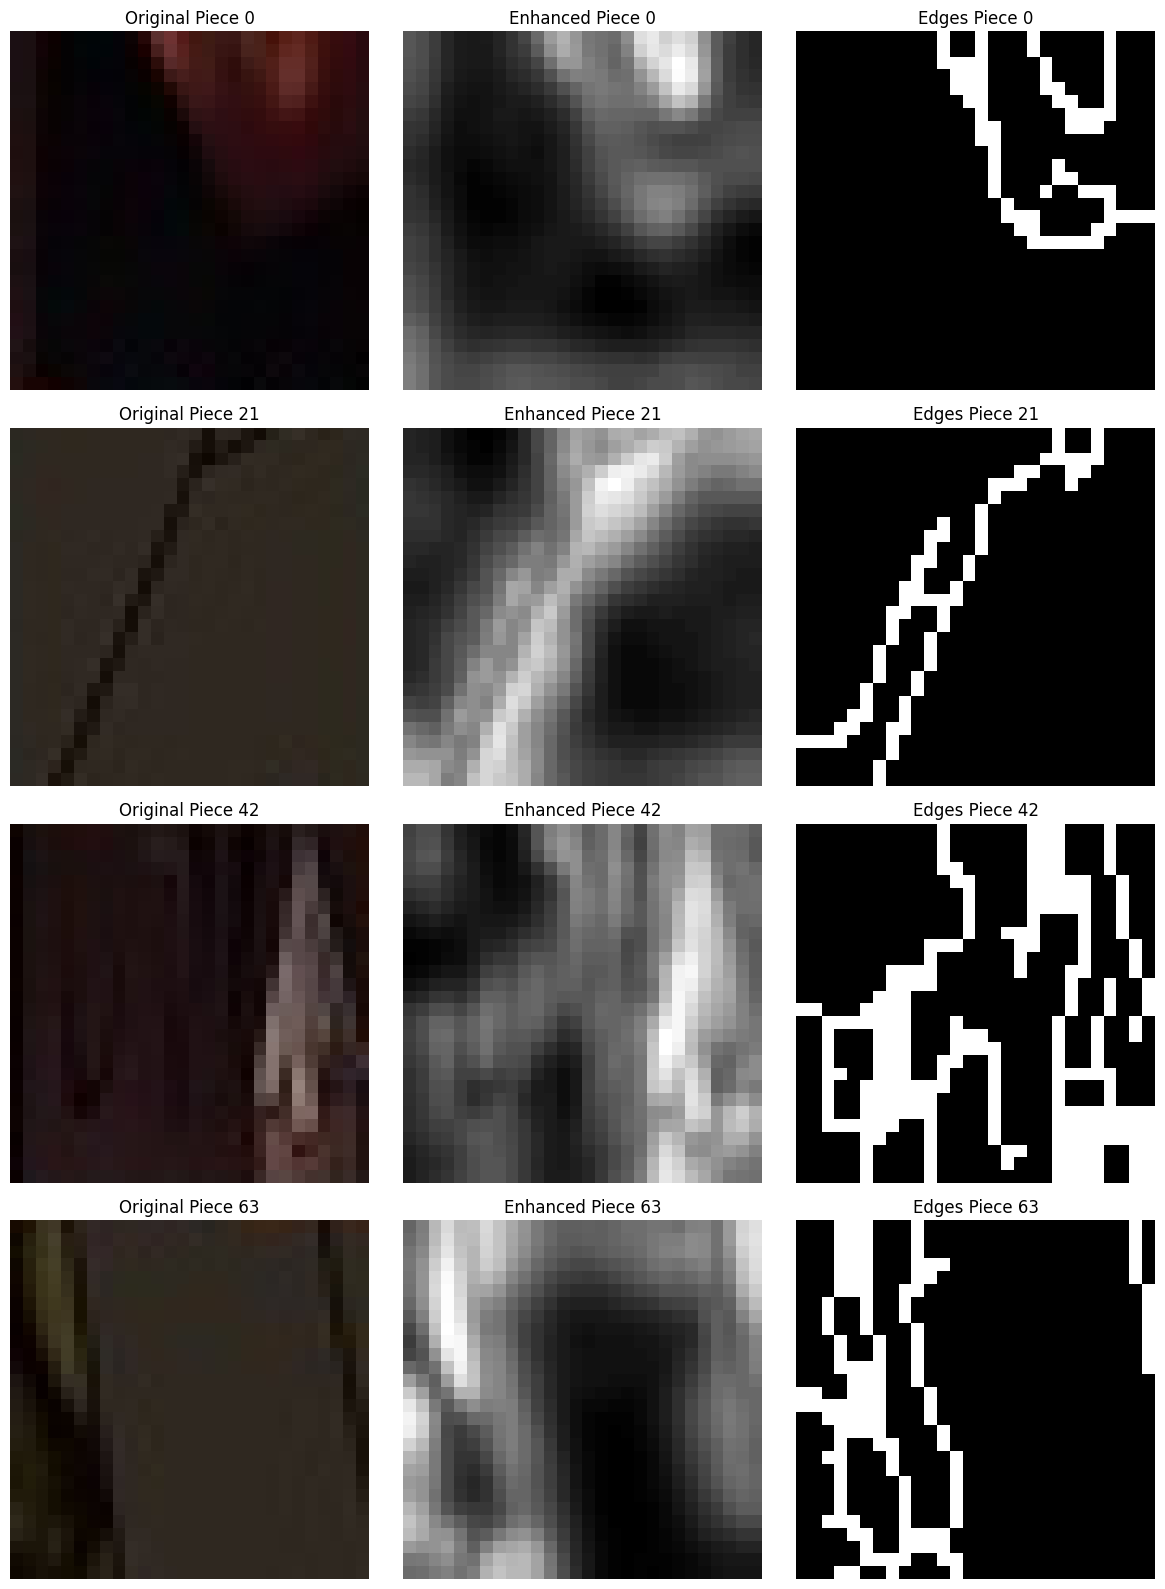

Processing puzzle_8x8/55...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_55
Processing puzzle_8x8/56...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_56
Processing puzzle_8x8/57...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_57
Processing puzzle_8x8/58...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_58
Processing puzzle_8x8/59...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_59
Processing puzzle_8x8/6...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_6
Processing puzzle_8x8/60...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_60
Processing puzzle_8x8/61...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_61
Processing puzzle_8x8/62...
  Split into 64 pieces
  Saved artifacts to ./processed_artifa

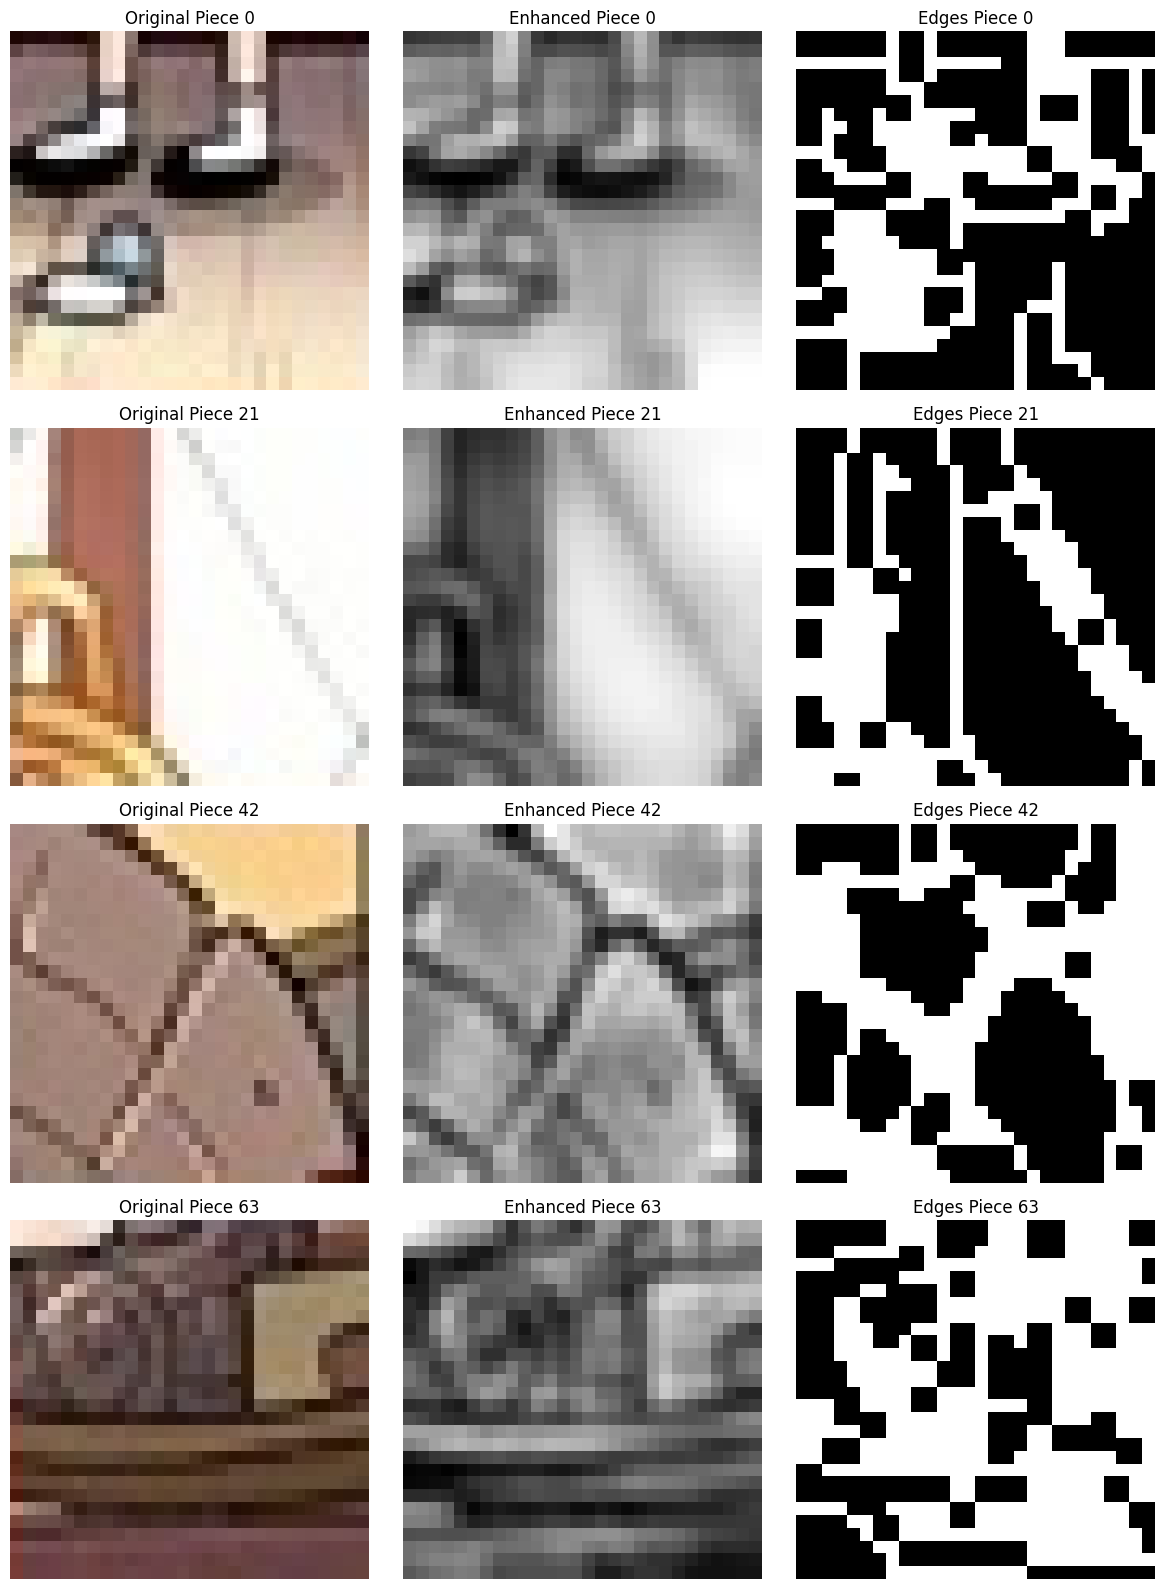

Processing puzzle_8x8/64...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_64
Processing puzzle_8x8/65...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_65
Processing puzzle_8x8/66...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_66
Processing puzzle_8x8/67...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_67
Processing puzzle_8x8/68...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_68
Processing puzzle_8x8/69...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_69
Processing puzzle_8x8/7...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_7
Processing puzzle_8x8/70...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_70
Processing puzzle_8x8/71...
  Split into 64 pieces
  Saved artifacts to ./processed_artifa

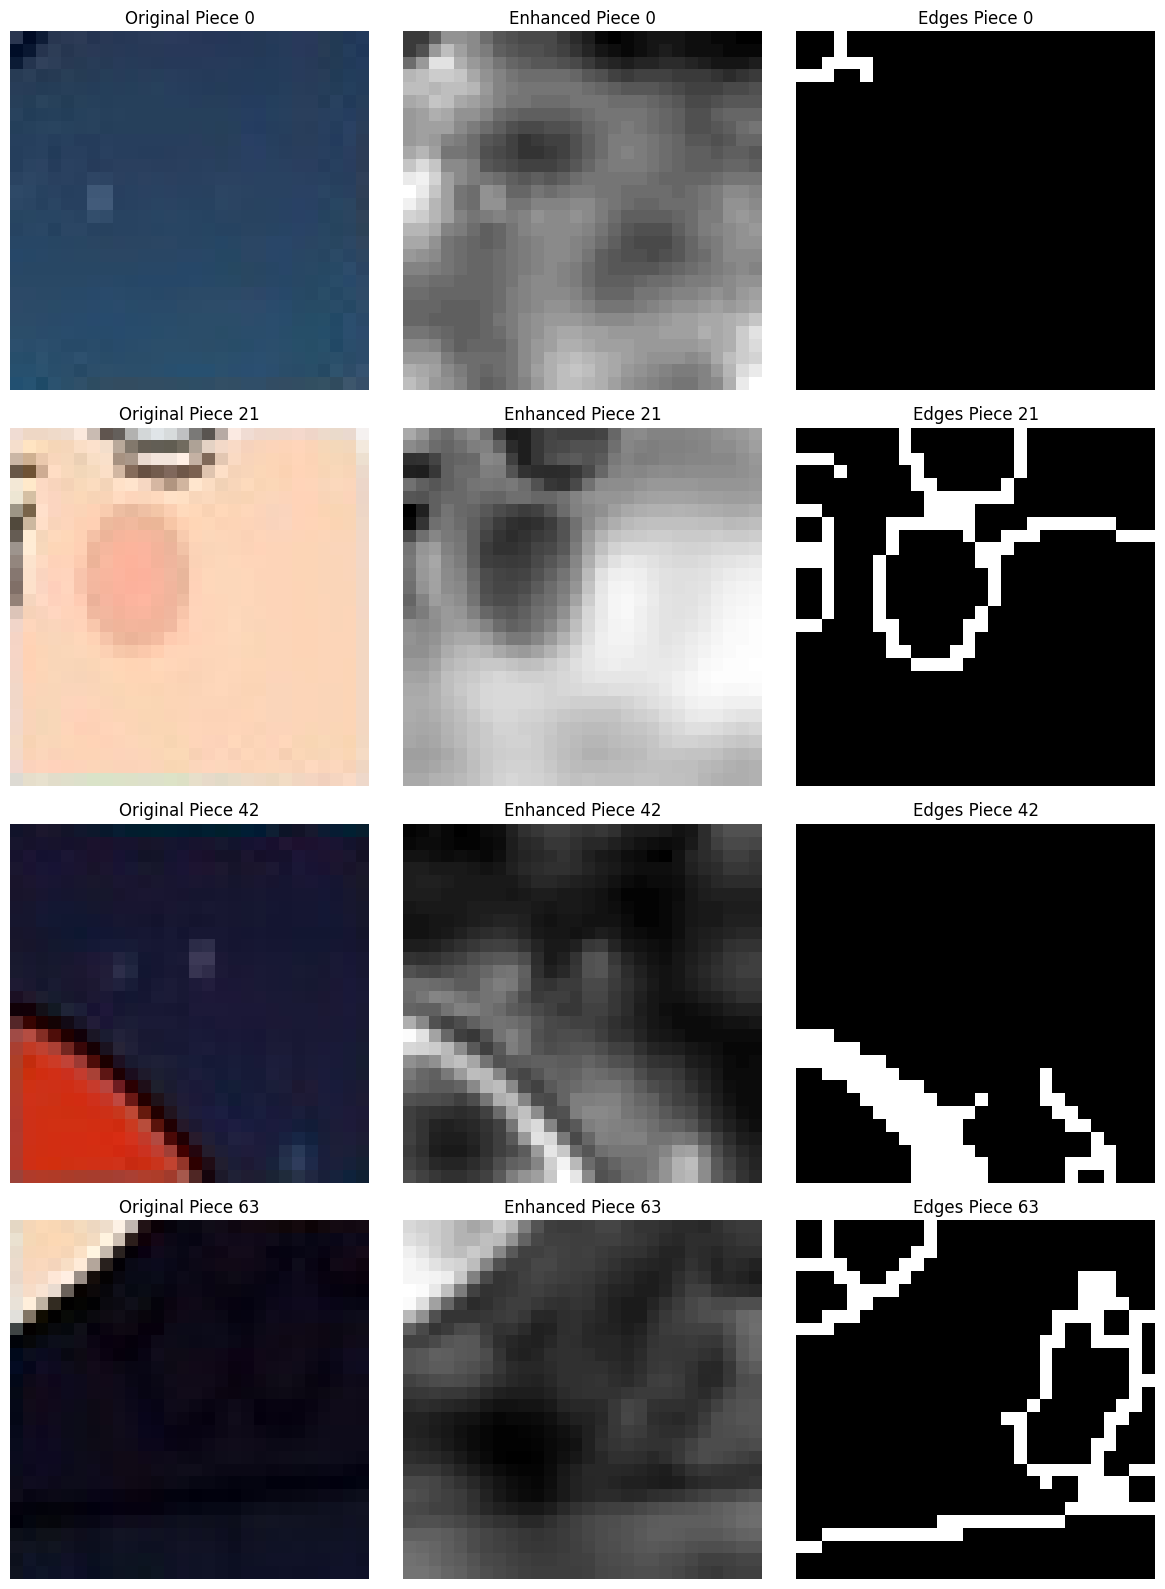

Processing puzzle_8x8/73...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_73
Processing puzzle_8x8/74...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_74
Processing puzzle_8x8/75...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_75
Processing puzzle_8x8/76...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_76
Processing puzzle_8x8/77...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_77
Processing puzzle_8x8/78...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_78
Processing puzzle_8x8/79...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_79
Processing puzzle_8x8/8...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_8
Processing puzzle_8x8/80...
  Split into 64 pieces
  Saved artifacts to ./processed_artifa

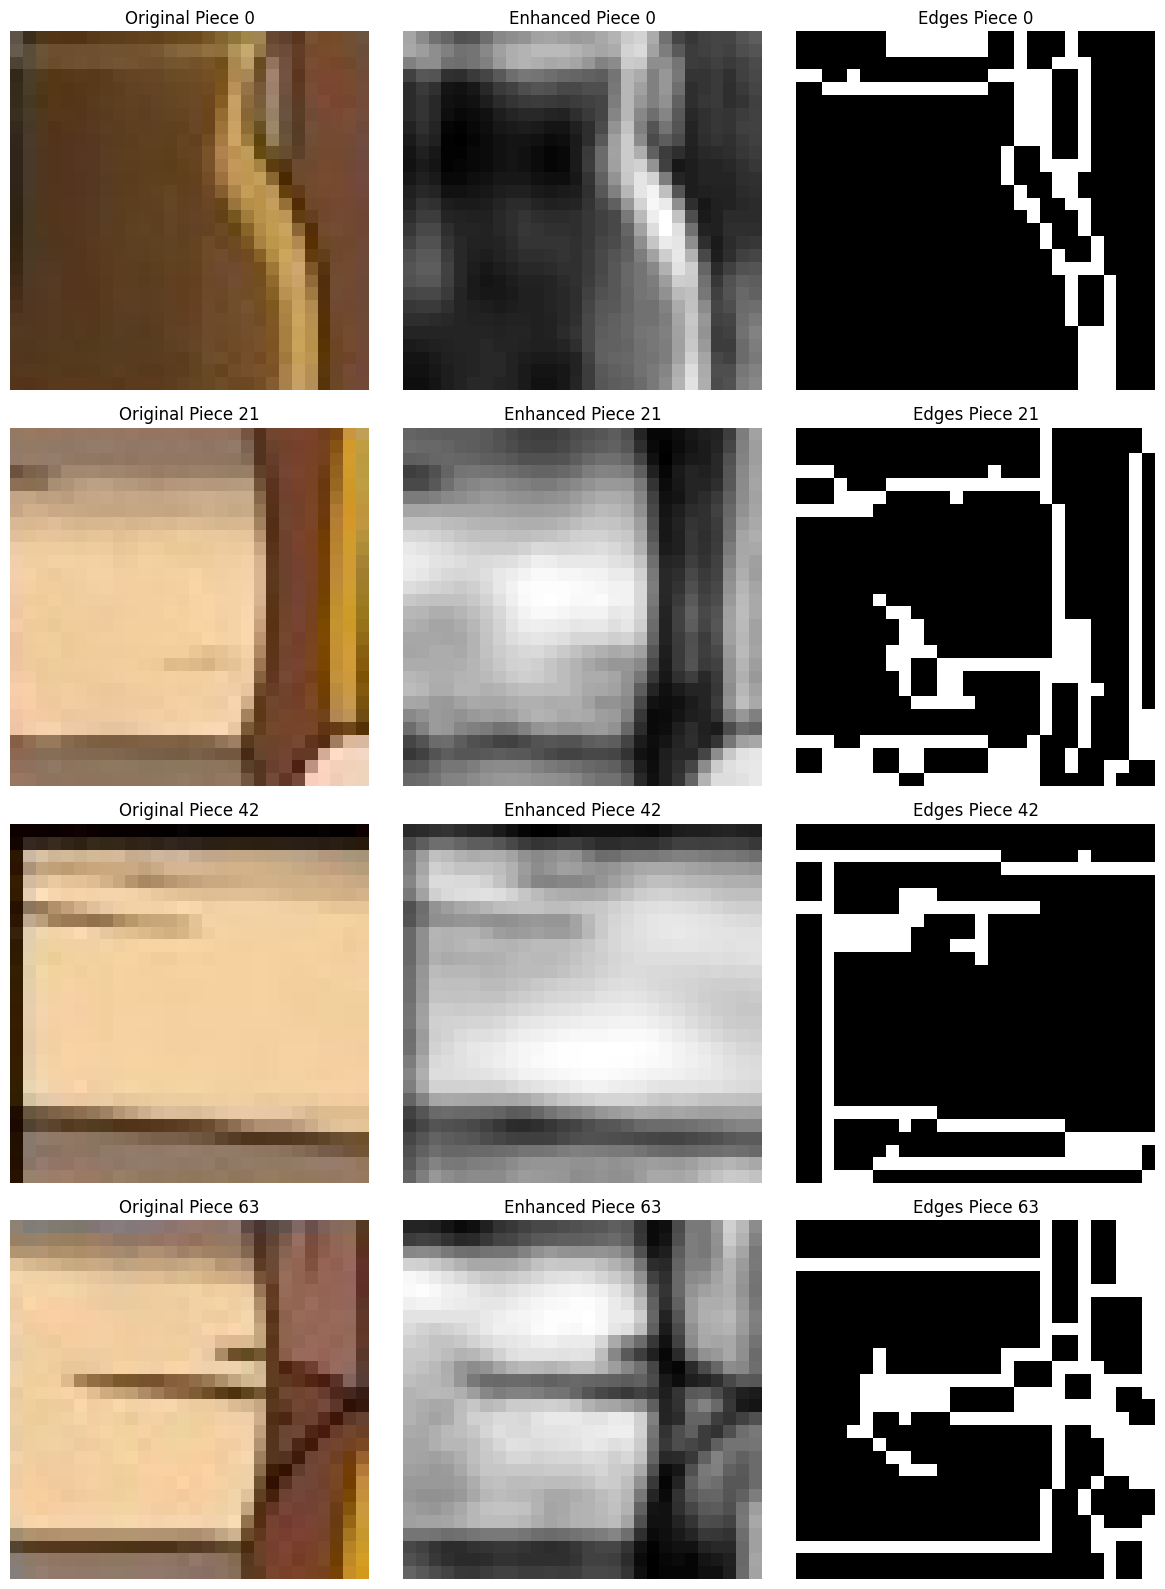

Processing puzzle_8x8/82...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_82
Processing puzzle_8x8/83...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_83
Processing puzzle_8x8/84...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_84
Processing puzzle_8x8/85...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_85
Processing puzzle_8x8/86...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_86
Processing puzzle_8x8/87...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_87
Processing puzzle_8x8/88...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_88
Processing puzzle_8x8/89...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_89
Processing puzzle_8x8/9...
  Split into 64 pieces
  Saved artifacts to ./processed_artif

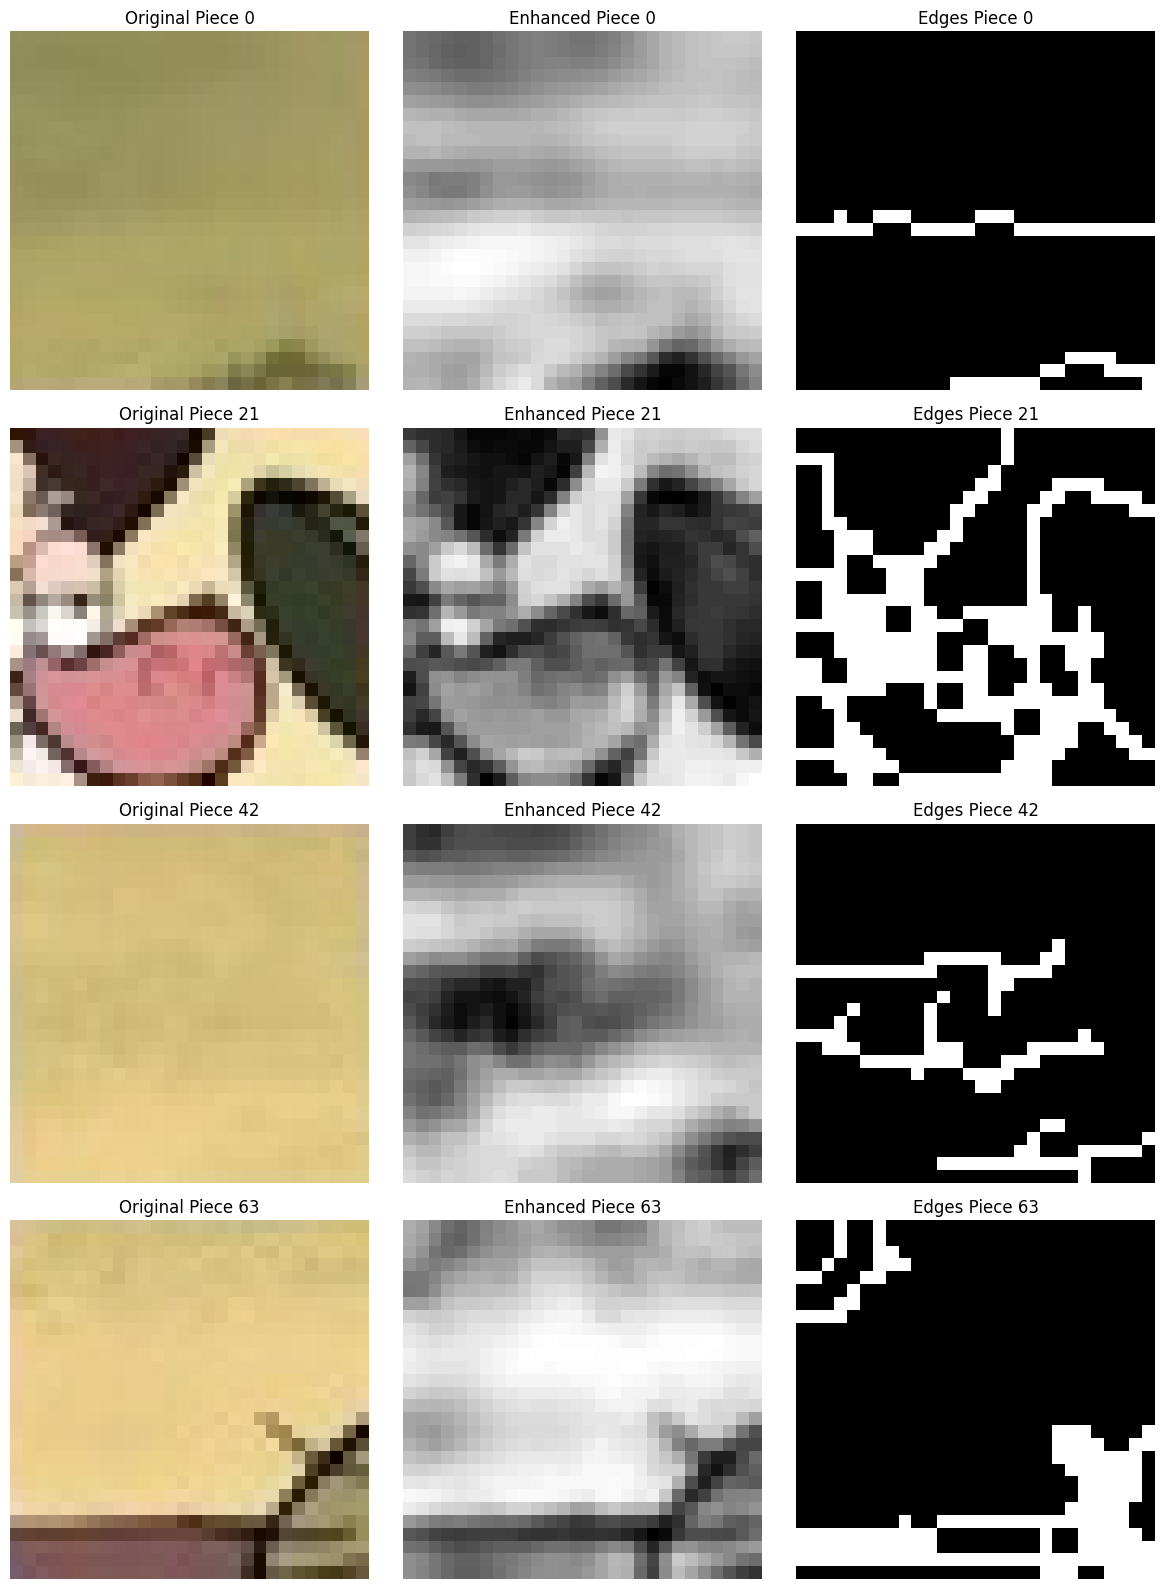

Processing puzzle_8x8/91...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_91
Processing puzzle_8x8/92...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_92
Processing puzzle_8x8/93...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_93
Processing puzzle_8x8/94...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_94
Processing puzzle_8x8/95...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_95
Processing puzzle_8x8/96...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_96
Processing puzzle_8x8/97...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_97
Processing puzzle_8x8/98...
  Split into 64 pieces
  Saved artifacts to ./processed_artifacts\puzzle_8x8\image_98
Processing puzzle_8x8/99...
  Split into 64 pieces
  Saved artifacts to ./processed_arti

In [29]:
# Process entire dataset
# Uncomment the line below to process all images
results, summary = process_dataset(BASE_DIR, OUTPUT_DIR, max_images_per_type=None, visualize_every_n=10)

# Or process a subset for testing:
# results, summary = process_dataset(BASE_DIR, OUTPUT_DIR, max_images_per_type=5, visualize_every_n=1)


## 8. View Processing Summary


In [30]:
# Load and display processing summary
summary_path = os.path.join(OUTPUT_DIR, 'processing_summary.json')

if os.path.exists(summary_path):
    with open(summary_path, 'r') as f:
        summary = json.load(f)
    
    print("Processing Summary:")
    print(f"Total images processed: {summary['total_images_processed']}")
    print("\nResults by puzzle type:")
    for puzzle_type, count in summary['results_by_type'].items():
        print(f"  {puzzle_type}: {count} images")
    print("\nProcessing parameters:")
    for param, value in summary['processing_parameters'].items():
        print(f"  {param}: {value}")
else:
    print("No summary file found. Run batch processing first.")


Processing Summary:
Total images processed: 321

Results by puzzle type:
  puzzle_2x2: 101 images
  puzzle_4x4: 110 images
  puzzle_8x8: 110 images

Processing parameters:
  gaussian_kernel_size: [5, 5]
  canny_low: 50
  canny_high: 150
  clahe_clip_limit: 2.0
  clahe_tile_size: [8, 8]
